# Import Packages

In [1]:
# importing all the necessary packages
import pandas as pd # Dataframe package
import matplotlib.pyplot as plt # Plotting package
import numpy as np # Numerical computation package
import seaborn as sns # Plotting package
from sklearn.neural_network import MLPRegressor # neural network 
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from PIL import Image
from datetime import date, timedelta
from datetime import datetime

np.random.seed(1) # Set the random seed so that the results stay the same

# Data cleaning

In [2]:
# Import the pedestriant data, national holidays and school holidays
ped = pd.read_csv("data/pedestrian_cologne-20180430-20200131-hour.csv", sep = ";")
holi = pd.read_csv("data/national_holidays_2018.01.01_2020.01.31.csv", sep = ";")
school_holi = pd.read_csv("data/school_holidays_17-18_19-20.csv", sep = ";")

# Splitting up the time of measurement into date and time
ped[["date", "time"]] = ped["time of measurement"].str.split(" ", n=1, expand=True)
# Drop the time of measurement, because it is split now and drop location
ped = ped.drop(["time of measurement", "location"], axis=1)
#Drop all columns with nan (Incidents are the only one)
ped.dropna(how='all', axis=1, inplace=True)
# Restructure by date and time in the first columns
ped = ped[ ["date", "time"] + [ col for col in ped.columns if col != "date" and col!= "time"] ]
# Clear time from the minute variation
ped["time"] = ped["time"].str.slice_replace(8, 16)


# Change the column name in the holiday df to holiday to recognise it later in the merged frame
holi = holi.rename(columns={"name": "holiday"})
# Merge the two dataframes on the pedestriant data
ped = pd.merge(ped, holi, how = "left")


# Put hollyday as 1 and no holyday as 0
ped["holiday"] = ped["holiday"].fillna(0)
ped["holiday"] = ped["holiday"].where(ped["holiday"] == 0, 1)

ped[ped.isnull().any(axis=1)].shape
# See where the data are missing
print(f"There are {len(ped[ped.isnull().any(axis=1)])} rows with missing data")
#
# Printing result: There are 27 rows with missing data
#
# Because the data for temperature and weather condition are both missing, those 27 rows can be dropped, due to the huge sample size
ped.dropna(inplace=True)


# Create a list to store all dataframes with the seperate school holidays, because the sheet only lists the first and last date
days_df_list = []
# Create a dataframe with all dates for each school holiday
for i in range(school_holi.shape[0]):
    # Get the start and enddate from the holidays
    start_date = datetime.strptime(school_holi["ErsterTagDate"][i], "%d.%m.%Y").date()
    end_date = datetime.strptime(school_holi["LetzterTagDate"][i], "%d.%m.%Y").date()
    # Create dataframes out of the range of those dates and append to the list
    delta = end_date - start_date
    days = [start_date + timedelta(days=n) for n in range(delta.days + 1)]
    days_df = pd.DataFrame (days, columns = ['date'])
    days_df_list.append(days_df)

# Create one single dataframe out of the list and add value 1 for a holiday
new_holi = pd.concat(days_df_list).reset_index(drop=True)
new_holi["school holiday"] = 1
# Change the formate of the date to a string for the merge
new_holi["date"] = new_holi["date"].astype(str)
# Merg of the two frames and fill the empty school holiday flieds with a 0
ped = pd.merge(ped, new_holi, how = "left", on="date")
ped["school holiday"] = ped["school holiday"].fillna(0)

# Change the float to integers
ped["school holiday"] = np.int64(ped["school holiday"].astype(int))


#Get Column with months
ped["months"] = ped["date"].str.slice(5, 7)
#Transform time to hours
ped["hour"] = ped["time"].str.slice(0, 2)


# Save this dataframe for the API without dummies to create them later manually
ped.to_csv("data/data_clean_without_dummies.csv", sep = ";")


# Get dummies for the weekdays, the weatherconditions, the months and the hours
ped = pd.get_dummies(ped, columns=["weekday", "weather condition", "months", "hour"])

# Standardize the temperature column for PCA
standardize = lambda x: (x - x.mean()) / x.std()
ped["temperature in ºc"] = standardize(ped["temperature in ºc"])
# Safe all features to calculate the cpa
features = ped.columns[3:] # Features
# Create new column names for the PCA
principal_components = [f"PC{i+1}" for i in range(len(features))]
# Run PCA on our data and safe them in the new columns
pca = PCA(n_components=len(features))
ped[principal_components] = pca.fit_transform(ped[features])


# Calculate the threshold  to get a 99%  mean explained variance and print the result
threshhold = 0.99
pca_n = np.argmax(pca.explained_variance_ratio_.cumsum() >= threshhold)
print(f"There are needed {pca_n} columns to preserve a {threshhold} mean explained variance")
#
# Printing result: There are needed 46 columns to preserve a 0.99 mean explained variance
#

# Save prepeared data
ped.to_csv("data/data_clean_with_dummies.csv")

There are 27 rows with missing data
There are needed 46 columns to preserve a 0.99 mean explained variance


# Visualizing our Data

# Neural Network with MLP Regressor

In [14]:
# Importing the data and splitting it into a train and test set to work with
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

## Hyperparameter Tuning

### 1. Establish Base Scenario

In [15]:
# Initialize a neural network with the default parameters 
nnet_base = MLPRegressor(random_state=42)

In [21]:
# Scale the data to work so it is less sensitive to feature scaling 
# normally we wouldn't use scaling if we already applied PCA to our data
# MLP Regressor doesn't work otherwise and has problems with matrix multiplication
# therefore we use scaling of the features and outputs in this prediction model
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest)
Xtest_scaled = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std()
ytest_scaled = (ytest - mu) / sigma
ytrain_scaled = (ytrain - mu) /sigma

In [51]:
# creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# defining a function to fit the scenario and evaluate it
def scenario_fit_evaluate_scaled(model, display_name, scenario, traindataX_sc, traindatay_sc, testdataX_sc, testdatay_sc):
    global comparison
    # Fit the network to the scaled train data
    scenario.fit(traindataX_sc, traindatay_sc)

    # Make predictions
    ypred_train_scaled = scenario.predict(traindataX_sc)
    ypred_scaled = scenario.predict(testdataX_sc)

    # Reconstruct outputs and scale back predictions
    ytest = testdatay_sc * sigma + mu
    ytrain = traindatay_sc * sigma + mu
    ypred_train = ypred_train_scaled * sigma + mu
    ypred = ypred_scaled * sigma + mu
    # the network predicts negative values because it is not possible to put an activation function on the output layer
    # MLPRegressor uses the activation function only on the hidden layers
    # Negative Values make no sense in our case, therefore we fix it and tell the network that all negative values
    # should equal to zero
    ypred[ypred < 0] = 0

    # Compute the MAE
    mae_train = mean_absolute_error(ytrain, ypred_train)
    mae_test = mean_absolute_error(ytest, ypred)
    # Comute R^2
    r2_train = r2_score(ytrain, ypred_train)
    r2_test = r2_score(ytest, ypred)

    # adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("outputs/comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [23]:
scenario_fit_evaluate_scaled("MLP Regressor", "Base Scenario", nnet_base, 
    Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  349.732476  457.666502  0.964785  0.941682


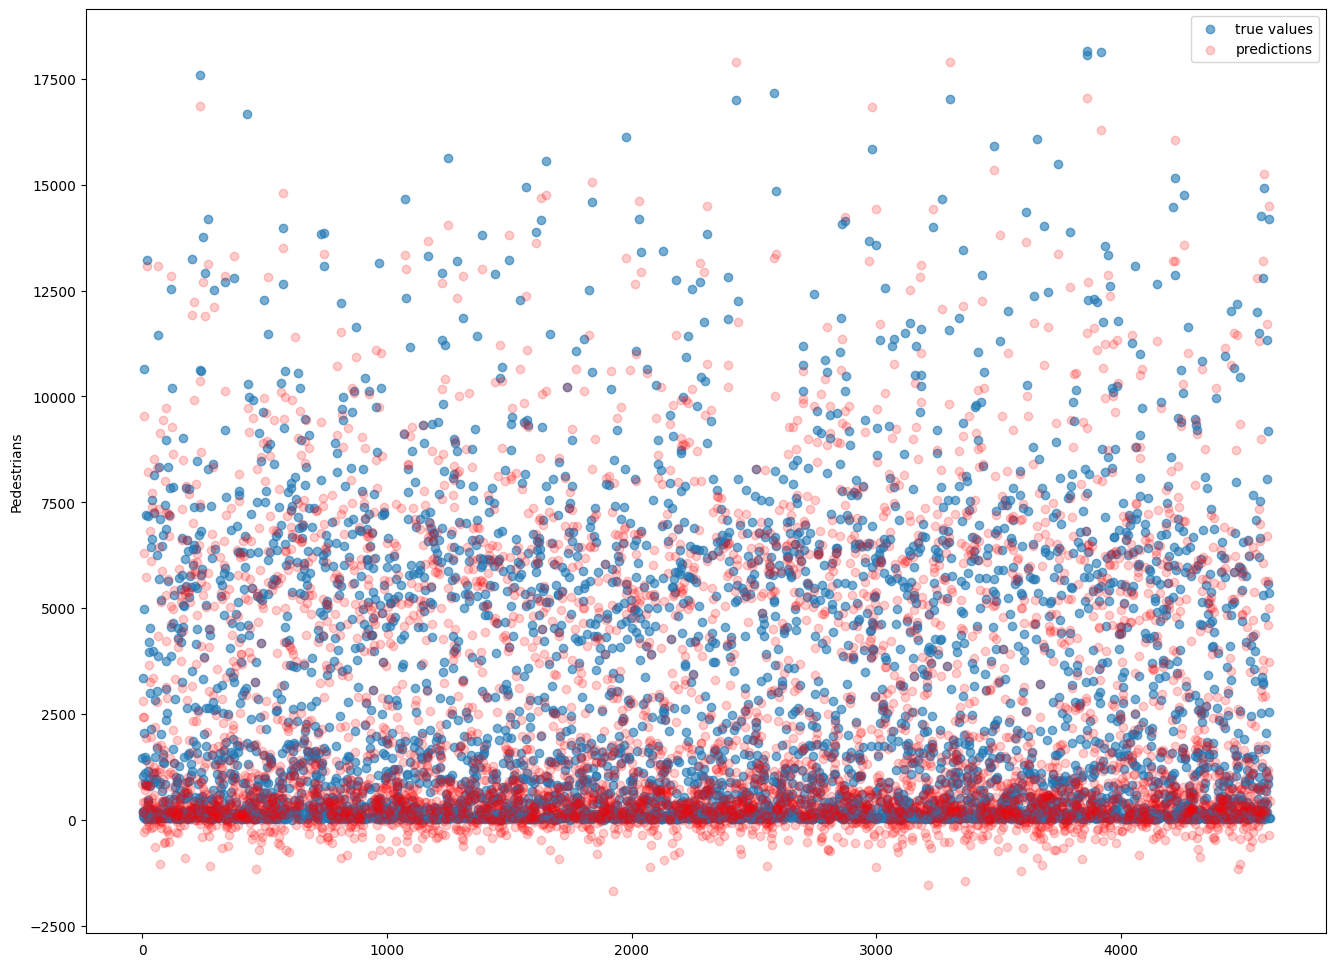

In [24]:
def plot_baseline_scaled(model, Xtest_scaled, ytest):
    # plot the results to see the results of our base scenario
    fig, ax = plt.subplots(figsize=(16, 12))

    #create a linspace to match the y-values
    xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

    # plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="true values", alpha=0.6)

    # plot the predictions
    ypred_scaled = model.predict(Xtest_scaled)
    ypred = ypred_scaled * sigma + mu
    ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)
    # there are negative values as a prediction of pedestrians because with MLP Regressor it is not possible to 
    # put an activation function on the output layer, it only works on the hidden layers
    # therefore in further predictions all values of ypred < 0 are going to be 0, so the scenario makes sense

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()

# apply the funtion to the data and calculations    
plot_baseline_scaled(nnet_base, Xtest_scaled, ytest)

### 2. Analyze the Influence of the Different Parameters

In [ ]:
# conduncting the parameter analysis on the most used parameters for optimization
# how many hidden layers with how many neurons are we going to use
# 100 is the default value, other values chosen randomly to see the effect of more layers
hidden_layer_sizes = [(100,), (32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)]
# activation function that is going to be used on the hidden layers, relu is the default value
activations = ["relu", "logistic", "tanh", "identity"]
# the solver which optimizes the weights, adam is the default value
solvers = ["sgd", "adam"]
# regularization: avoids overfitting, 0.0001 is the default value
alphas = np.linspace(0.00001, 0.001, 50)
# how high is the initial learing rate, 0.001 is the default value
learing_rate_inits = np.linspace(0.001, 0.01, 50)
# number of epochs, 200 is the default value
# often it doesn't converge then so we start at 1000
max_iters = range(1000, 2000, 250)

names_parameters = ["hidden_layer_size", "activation", "solver", "alpha", "learning_rate_init", "max_iter"]

In [ ]:
# creating a dataframe to save the results
results = pd.DataFrame(columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter_scaled(model, param, param_values, initialize_model):
    global results
    for param_value in param_values:
        nnet_param = initialize_model(param_value)
        # Fit the network to the train data
        nnet_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_param_train_scaled = nnet_param.predict(Xtrain_scaled)
        ypred_param_scaled = nnet_param.predict(Xtest_scaled)

        # Reconstruct outputs and scale predictions
        ypred_param_train = ypred_param_train_scaled * sigma + mu
        ypred_param = ypred_param_scaled * sigma + mu
        ypred_param[ypred_param < 0] = 0 # all neg values equal zero to make sense
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_param_train)
        mae_param_test = mean_absolute_error(ytest, ypred_param)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_param_train)
        r2_param_test = r2_score(ytest, ypred_param)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[model, param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])

# apply the function to the different parameters
test_parameter_scaled("MLP Regressor", "hidden_layer_size", hidden_layer_sizes, lambda value: MLPRegressor(hidden_layer_sizes=value, random_state=72))
test_parameter_scaled("MLP Regressor", "activation", activations, lambda value: MLPRegressor(activation=value, random_state=72))
test_parameter_scaled("MLP Regressor", "solver", solvers, lambda value: MLPRegressor(solver=value, random_state=72))
test_parameter_scaled("MLP Regressor", "alpha", alphas, lambda value: MLPRegressor(alpha=value, random_state=72))
test_parameter_scaled("MLP Regressor", "learning_rate_init", learing_rate_inits, lambda value: MLPRegressor(learning_rate_init=value, random_state=72))
test_parameter_scaled("MLP Regressor", "max_iter", max_iters, lambda value: MLPRegressor(max_iter=value, random_state=72))

# merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("outputs/param_testing.csv", sep=";", index=False)

In [25]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("outputs/param_testing.csv", sep=";")
param_testing

Parameter         ParameterValue    MaeTrain     MaeTest  \
0    hidden_layer_size                 (100,)  347.696832  441.015174   
1    hidden_layer_size           (32, 64, 32)  297.319744  429.473338   
2    hidden_layer_size          (64, 128, 64)  297.511867  434.913581   
3    hidden_layer_size  (32, 64, 128, 64, 32)  244.434975  447.374537   
4           activation                   relu  347.696832  441.015174   
..                 ...                    ...         ...         ...   
155           max_iter                   1900  347.696832  441.015174   
156           max_iter                   1920  347.696832  441.015174   
157           max_iter                   1940  347.696832  441.015174   
158           max_iter                   1960  347.696832  441.015174   
159           max_iter                   1980  347.696832  441.015174   

      R2Train    R2Test  
0    0.964892  0.943029  
1    0.972019  0.931705  
2    0.973874  0.927148  
3    0.979625  0.919673  
4    0.964892  0.943029  
..        ...       ...  
155  0.964892  0.943029  
156  0.964892  0.943029  
157  0.964892  0.943029  
158  0.964892  0.943029  
159  0.964892  0.943029  

[160 rows x 6 columns]

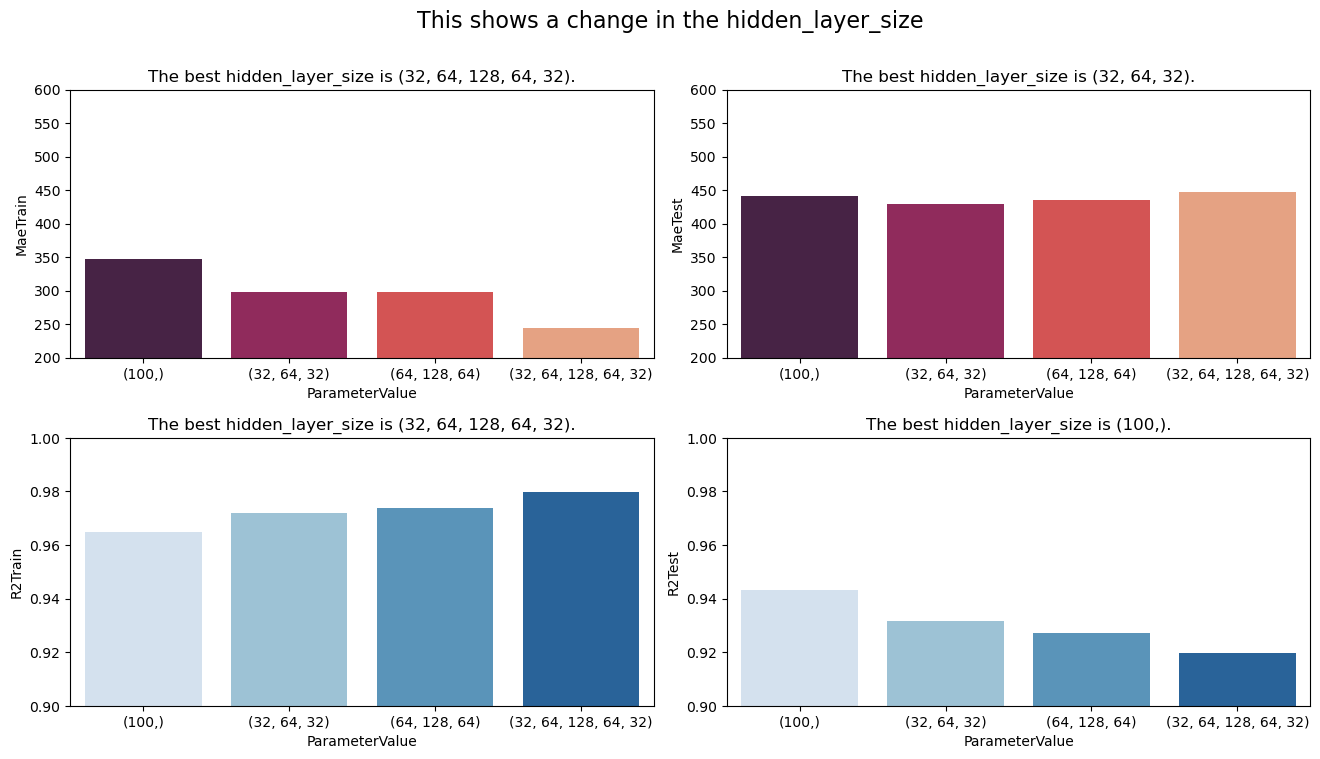

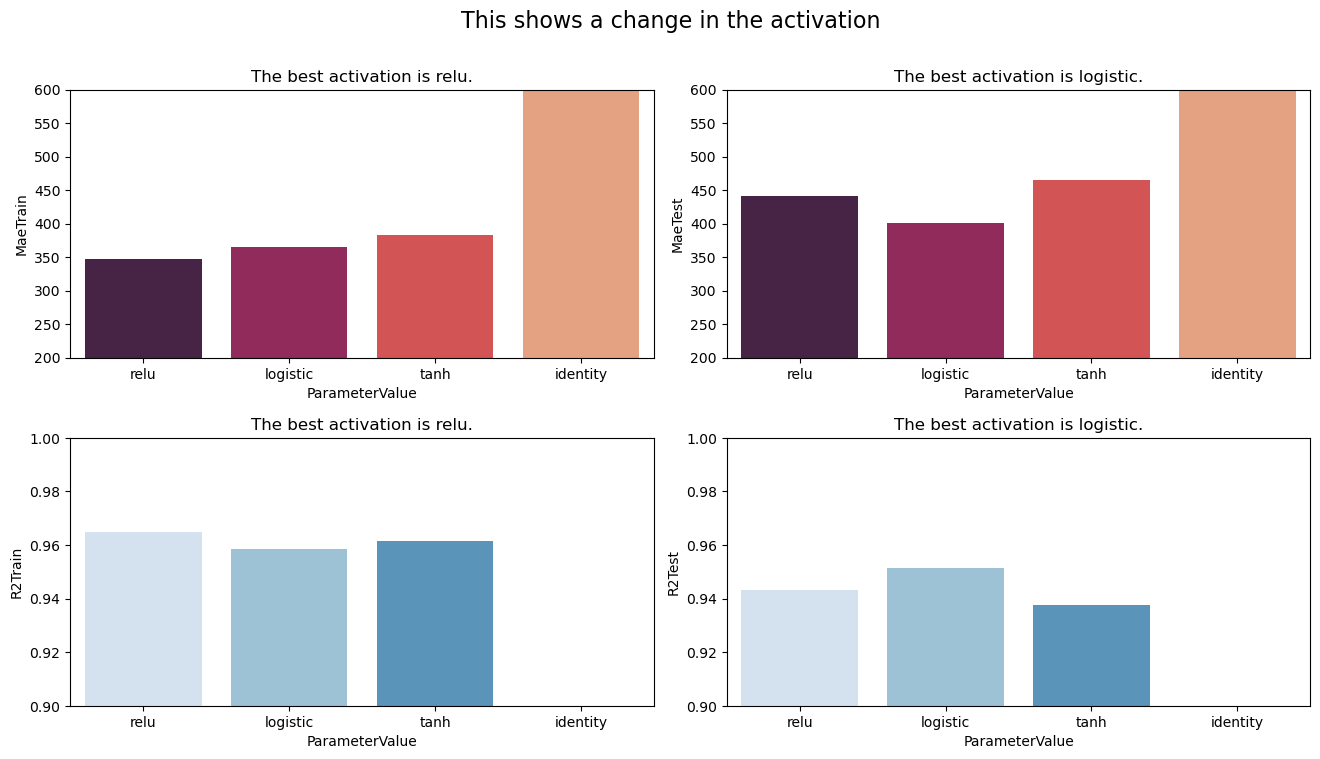

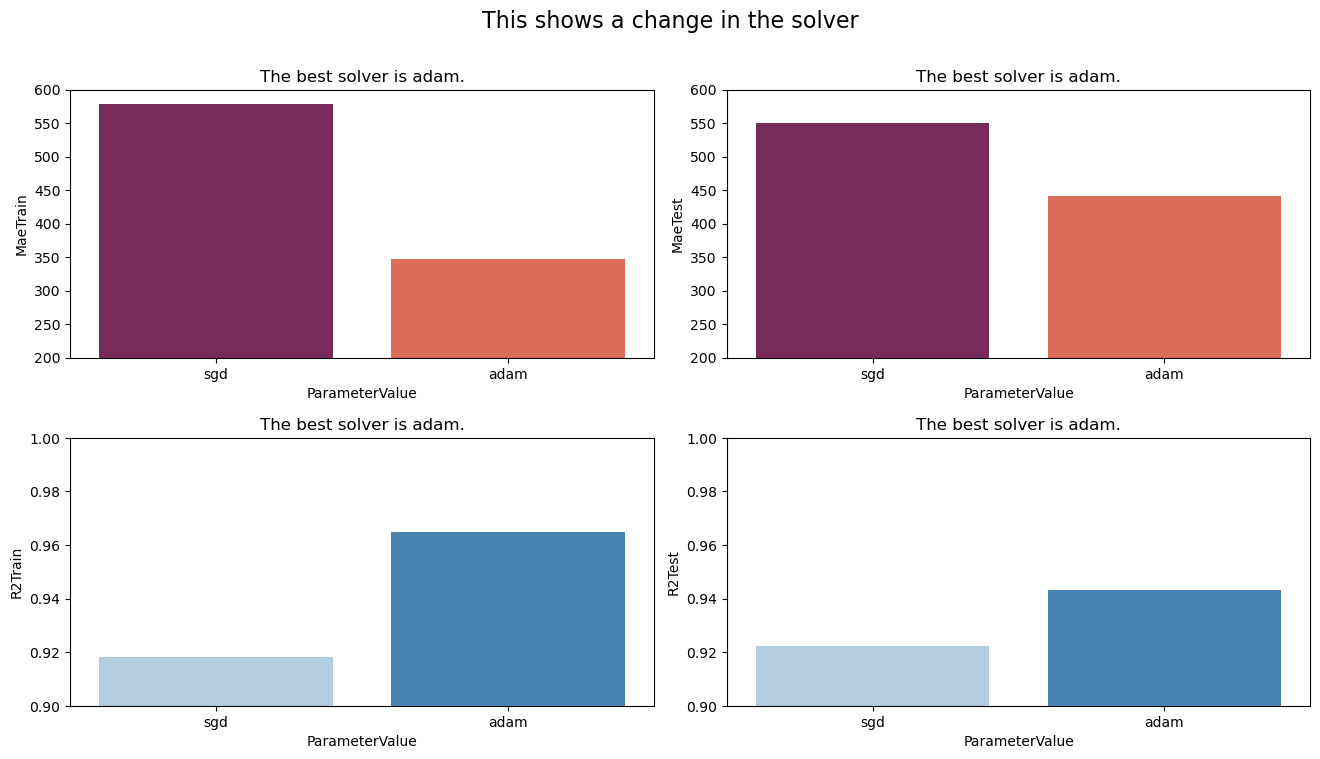

In [195]:
# defining a function for barplots for some of the parameters to compare mae and r2
def plot_bars(data_filter_model, data_filter_parameter):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter_parameter]

    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTrain", ax=mae_train_axes, palette="rocket")
    min_mae_train_df = plot_data[["ParameterValue", "MaeTrain"]]
    min_mae_train = min_mae_train_df["MaeTrain"].min()
    min_mae_train_df = min_mae_train_df[min_mae_train_df["MaeTrain"] == min_mae_train]
    min_mae_train = min_mae_train_df["ParameterValue"].to_string(index=False)
    mae_train_axes.set_title(f"The best {data_filter_parameter} is {min_mae_train}.")
    mae_train_axes.set_ylim(200, 600)

    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTest", ax=mae_test_axes, palette="rocket")
    min_mae_test_df = plot_data[["ParameterValue", "MaeTest"]]
    min_mae_test = min_mae_test_df["MaeTest"].min()
    min_mae_test_df = min_mae_test_df[min_mae_test_df["MaeTest"] == min_mae_test]
    min_mae_test = min_mae_test_df["ParameterValue"].to_string(index=False)
    mae_test_axes.set_title(f"The best {data_filter_parameter} is {min_mae_test}.")
    mae_test_axes.set_ylim(200, 600)

    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Train", ax=r2_train_axes, palette="Blues")
    max_r2_train_df = plot_data[["ParameterValue", "R2Train"]]
    max_r2_train = max_r2_train_df["R2Train"].max()
    max_r2_train_df = max_r2_train_df[max_r2_train_df["R2Train"] == max_r2_train]
    max_r2_train = max_r2_train_df["ParameterValue"].to_string(index=False)
    r2_train_axes.set_title(f"The best {data_filter_parameter} is {max_r2_train}.")
    r2_train_axes.set_ylim(0.9, 1)

    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Test", ax=r2_test_axes, palette="Blues")
    max_r2_test_df = plot_data[["ParameterValue", "R2Test"]]
    max_r2_test = max_r2_test_df["R2Test"].max()
    max_r2_test_df = max_r2_test_df[max_r2_test_df["R2Test"] == max_r2_test]
    max_r2_test = max_r2_test_df["ParameterValue"].to_string(index=False)
    r2_test_axes.set_title(f"The best {data_filter_parameter} is {max_r2_test}.")
    r2_test_axes.set_ylim(0.9, 1)

    fig.suptitle(f"This shows a change in the {data_filter_parameter}", fontsize=16)
    fig.subplots_adjust(hspace=0.5, wspace=0.125)
    fig.savefig(f"plots/{data_filter_model}_{data_filter_parameter}.png")

# apply the function to wanted parameters for comparison
plot_bars("MLP Regressor", "hidden_layer_size")
plot_bars("MLP Regressor", "activation")
plot_bars("MLP Regressor", "solver")
# plotting the iterations as a bar because there is no difference at the different iteration times if the rest is default
# it would not be possible to calculate the standardized version for the lineplot
plot_bars("MLP Regressor", "max_iter")

KeyError: 'y'

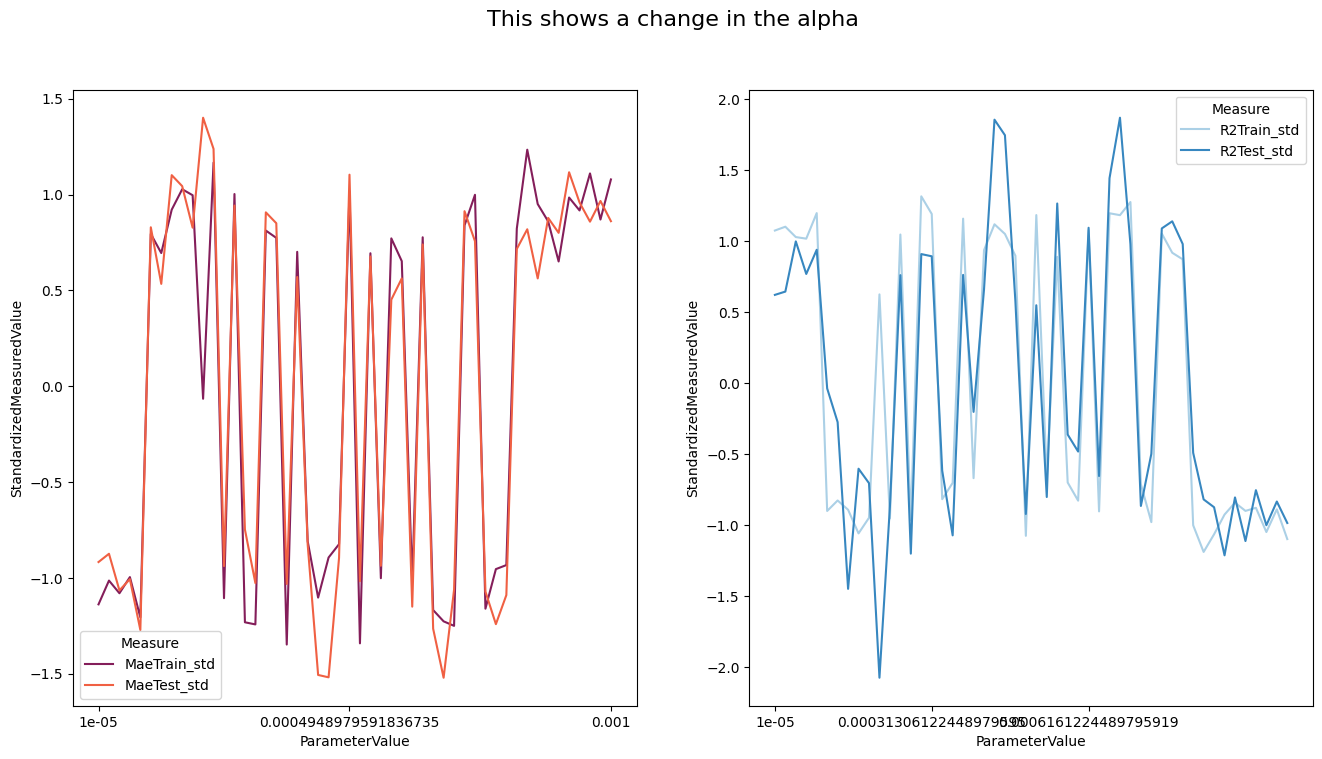

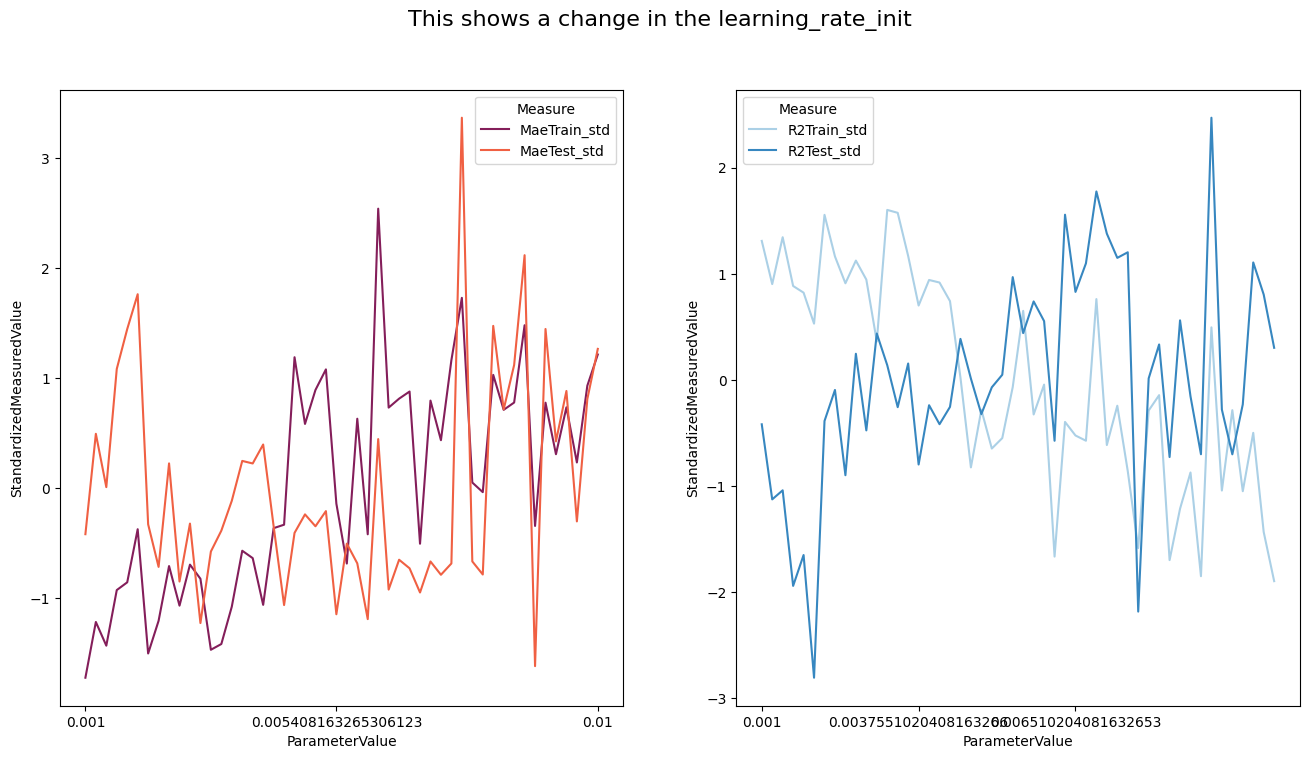

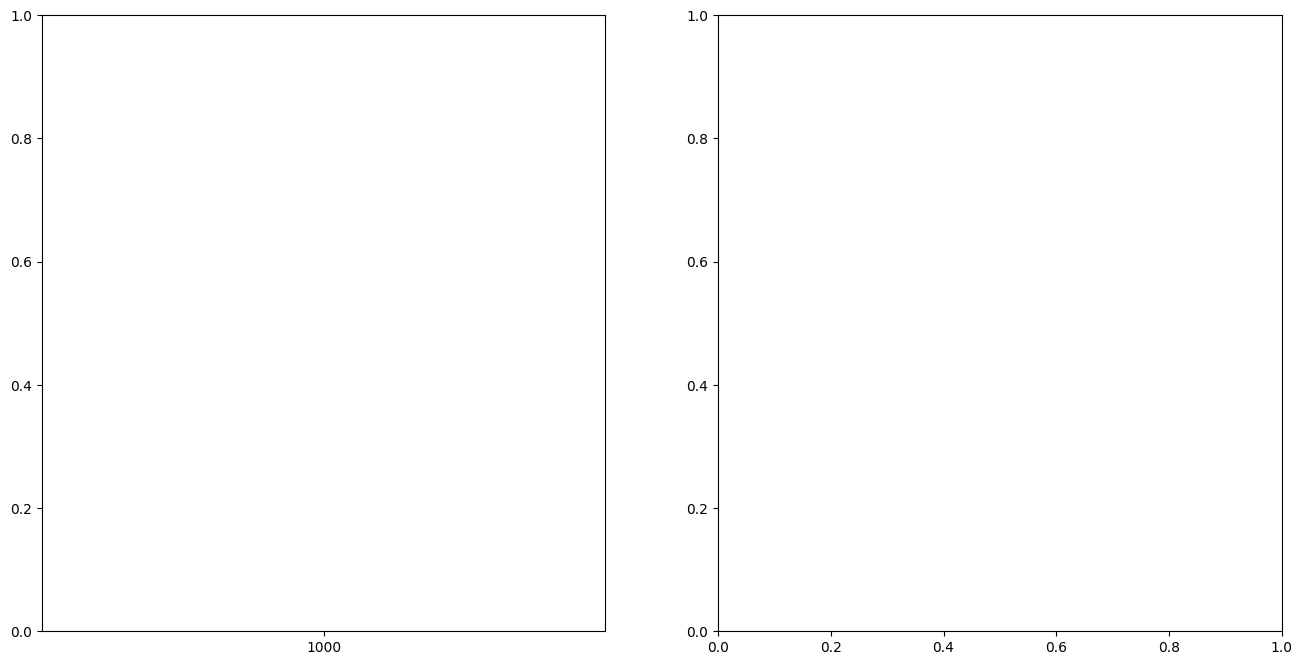

In [36]:
# Defining a function for standardization to have a better look at the change of the parameters
standardize_df_col = lambda df_c: (df_c - df_c.mean()) / df_c.std()

# Defining a function for lineplots for the parameters to compare mae and r2 for test and train data
def plot_lines(data_filter_model, data_filter_parameter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    # Filter the dataframe for the wanted Model and the wanted Parameter
    plot_data_all_param = param_testing[param_testing["Model"] == data_filter_model]
    plot_data = plot_data_all_param[plot_data_all_param["Parameter"] == data_filter_parameter]

    # Standardize the Values to see changes better and name them accordingly in new columns
    plot_data["MaeTrain_std"] = standardize_df_col(plot_data["MaeTrain"])
    plot_data["MaeTest_std"] = standardize_df_col(plot_data["MaeTest"])
    plot_data["R2Train_std"] = standardize_df_col(plot_data["R2Train"])
    plot_data["R2Test_std"] = standardize_df_col(plot_data["R2Test"])

    # Bring the data into a long format to plot them
    plot_data_std = pd.melt(plot_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain_std", "MaeTest_std", "R2Train_std", "R2Test_std"], value_name="StandardizedMeasuredValue")

    # Select the standadised mae data and plot them 
    mae_data = plot_data_std[plot_data_std["Measure"].isin(["MaeTrain_std", "MaeTest_std"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data_std[plot_data_std["Measure"].isin(["R2Train_std", "R2Test_std"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    r2_axes.set_xticks([0, 24, 49])

    fig.suptitle(f"This shows a change in the {data_filter_parameter}", fontsize=16)
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.savefig(f"plots/{data_filter_model}_{data_filter_parameter}.png")

# apply the function to wanted parameters for comparison
plot_lines("MLP Regressor", "alpha")
plot_lines("MLP Regressor", "learning_rate_init")

In [ ]:
##############################################################################
# USE YANNIKS
##############################################################################





# Define a function to create figure frome saved pictures
def show_images_parameter(model, parameter_list):
    fig = plt.figure(figsize=(16, 8*len(parameter_list)))
    
    # Set the row and column number
    rows = (len(parameter_list))
    columns = 1
    
    # Go throug all parameters of the model
    i = 1
    for parameter in parameter_list:
        # Reading images
        img = Image.open(f"plots/{model}_{parameter}.png")
        # Adds a subplot at the i position
        fig.add_subplot(rows, columns, i)
        i += 1
        # Showing the Image
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{parameter}")
    

show_images_parameter("MLP Regressor", names_parameters)

### 3. Optimize the Hyperparameters with the Findings above

In [125]:
# subsetting the data for the optimization of the hyperparameters
ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X of the subset with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

# Subset of the output to predict
y_subset = ped_subset["pedestrians count"]

# Split the subset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)

In [126]:
# scale the data of the subset, so it is less sensitive to feature scaling 
# scale the inputs
scaler.fit(Xtrain_subset)
Xtrain_scaled_subset = scaler.transform(Xtrain_subset)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest_subset)
Xtest_scaled_subset = scaler.transform(Xtest_subset)
# scale the y different because we can't use standardscaler to a 1d array
mu_subset, sigma_subset = y_subset.mean(), y_subset.std()
ytest_scaled_subset = (ytest_subset - mu_subset) / sigma_subset
ytrain_scaled_subset = (ytrain_subset - mu_subset) /sigma_subset

In [ ]:
# Definine a Base Model for the Subset
nnet_base_sub = MLPRegressor(random_state=42)
nnet_base_sub.fit(Xtrain_scaled_subset, ytrain_scaled_subset)

# Evaluate the basemodel for the Subset
scenario_fit_evaluate_scaled("MLP Regressor Subset", "Base Scenario", nnet_base_sub, 
    Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

In [129]:
# defining the model and the parameters used in RandomizedSearchCV
nnet_randomsearch = MLPRegressor(random_state=42)

parameters_randomsearch = {
    # choosing the two best hidden layer sizes and a range around them
    "hidden_layer_sizes": [(50,), (100,), (150,), (9, 18, 6), (32, 64, 32), (12, 24, 12)],
    "activation": ["logistic", "relu"], # choosing the two activation functions based on analysis above
    "solver": ["adam"], # adam was clearly the best solver in the plot above
    "alpha": np.linspace(0.00005, 0.0005, 20),
    "learning_rate_init" : np.linspace(0.0005, 0.001, 20),
    "max_iter" : range(1000, 2000, 100) # we look if the iterations have an efffect if there are other parameters that change
}

# Calculating the possibilities this gives us
length = [len(values) for key, values in parameters_randomsearch.items()]
print(f"In total we have {np.prod(length)} possibilities")

In [132]:
# running the RandomizedSearchCV on the subset of the data
nnet_rndm_src = RandomizedSearchCV(estimator=nnet_randomsearch, param_distributions=parameters_randomsearch, cv=3)
nnet_rndm_src.fit(Xtrain_subset, ytrain_subset)
print(nnet_rndm_src.best_params_)
# {'solver': 'adam', 'max_iter': 1300, 'learning_rate_init': 0.0005, 'hidden_layer_sizes': (9, 18, 6), 'alpha': 0.00021578947368421054, 'activation': 'relu'}

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'solver': 'adam',
 'max_iter': 1700,
 'learning_rate_init': 0.0006052631578947369,
 'hidden_layer_sizes': (9, 18, 6),
 'alpha': 0.00028684210526315793,
 'activation': 'relu'}

In [158]:
# creating a neural network with the results of the RandomSearchCV and the whole data and look at mae and r2
nnet_random = MLPRegressor(hidden_layer_sizes=(9, 18, 6), activation="relu", solver="adam", alpha=0.00021578947368421054,
    learning_rate_init=0.0005, max_iter=1300, random_state=42)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor Subset", "RandomSearch", nnet_random, Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584
1  MLP Regressor   RandomSearch  392.851111  410.187292  0.949453  0.947754


In [143]:
# use GridSearchCV to further optimize the parameters and run now all possibilities
# defining the model and the parameters used in GridSearchCV
nnet_gridsearch = MLPRegressor(random_state=42)

parameters_gridsearch = {
    "hidden_layer_sizes": [(9, 18, 6), (32, 64, 32)], # keeping (32, 64, 32) because it looked promising before and compare it to randomized optimum
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": np.append(np.linspace(0.0002, 0.0004, 3), [0.00021578947368421054]), # appending the best value of RandomSearch
    "learning_rate_init" : np.append(np.linspace(0.0004, 0.0006, 3), [0.0005]), # appending the best value of RandomSearch
    "max_iter" : range(1200, 1500, 100)
}


In [144]:
# running the GridSearchCV on the subset of the data
nnet_grid_src = GridSearchCV(estimator=nnet_gridsearch, param_grid=parameters_gridsearch, cv=3)
nnet_grid_src.fit(Xtrain_subset, ytrain_subset)
print(nnet_grid_src.best_params_)

# {'activation': 'relu', 'alpha': 0.00021578947368421054, 'hidden_layer_sizes': (32, 64, 32), 'learning_rate_init': 0.0006, 'max_iter': 1300, 'solver': 'adam'}

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'activation': 'relu',
 'alpha': 0.0003,
 'hidden_layer_sizes': (32, 64, 32),
 'learning_rate_init': 0.0005,
 'max_iter': 1300,
 'solver': 'adam'}

In [159]:
# creating a neural network with the results of GridSearchCV and the whole data and look at mae and r2
nnet_grid = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam", alpha=0.00021578947368421054,
    learning_rate_init=0.0006, max_iter=1300, random_state=42)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor Subset", "GridSearch", nnet_grid, Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584
1  MLP Regressor   RandomSearch  392.851111  410.187292  0.949453  0.947754
2  MLP Regressor     GridSearch  321.755799  442.351770  0.968152  0.934830


## Comparing the results of the 3 neural networks

In [160]:
# reading the created dataframe and have a look at it to plot it later for the analysis
comparison = pd.read_csv("outputs/comparison_mae_r2.csv", sep=";")
comparison

Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584
1  MLP Regressor   RandomSearch  392.851111  410.187292  0.949453  0.947754
2  MLP Regressor     GridSearch  321.755799  442.351770  0.968152  0.934830

(0.9, 1.0)

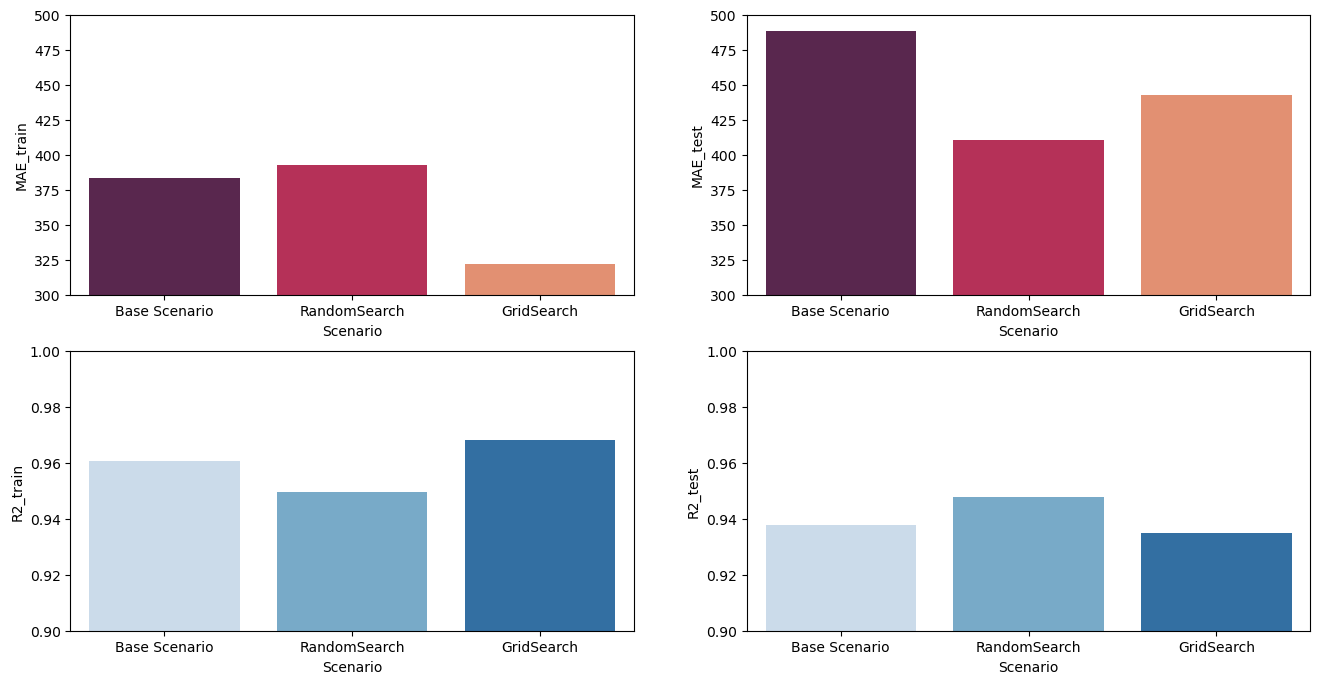

In [162]:
# Define a Function to plot the comparison of the models
def plot_bars_comp(model, dataframe):
    # Define the dimensions and model of the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_data = dataframe[dataframe["Model"] == model]

    # Get the MAE train bars
    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim((plot_data["MAE_train"].min())*0.9, (plot_data["MAE_train"].max())*1.1)
    mae_train_axes.set_title(f"The is the MAE Train for the Model with differen optimisations.")

    # Get the MAE test bars
    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim((plot_data["MAE_test"].min())*0.9, (plot_data["MAE_test"].max())*1.1)
    mae_test_axes.set_title(f"The is the MAE Test for the Model with differen optimisations.")


    # Get the r2 train bars
    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim((plot_data["R2_train"].min())*0.99, (plot_data["R2_train"].max())*1.01)
    r2_train_axes.set_title(f"The is the R^2 Train for the Model with differen optimisations.")


    # Get the r2 test bars
    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim((plot_data["R2_test"].min())*0.99, (plot_data["R2_test"].max())*1.01)
    r2_test_axes.set_title(f"The is the R^2 Test for the Model with differen optimisations.")

    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    # Set a Titel
    fig.suptitle(f"This shows a change in the {model}", fontsize=16)
    fig.savefig(f"plots/{model} comparison.png")


plot_bars_comp("MLP Regressor Subset", comparison)

In [ ]:
# Define a function to create figure frome saved pictures of the comaprison
def show_images_compa(model):
    fig = plt.figure(figsize=(16, 20))
    
    # Set the row and column number
    rows = 1
    columns = 1


    img = Image.open(f"plots/{model} comparison.png")
    # Adds a subplot at the i position
    fig.add_subplot(rows, columns, 1)

    # Showing the Image
    plt.imshow(img)
    plt.axis('off')
    

show_images_compa("MLP Regressor Subset")

### Optimization for the whole dataset

In [ ]:
# Setting up the first Hyperparameters that should be tuned, due to the size of the Dataset only very few
# Number of trees in random forest
hidden_layer_sizes = [(9, 18, 6), (32, 64, 32)]
# to avoid overfittig
alpha = np.linspace(0.0002, 0.0004, 3)
# Method to controll complexity 
learning_rate_init = np.linspace(0.0004, 0.0006, 3)

param_grid = {"hidden_layer_sizes": hidden_layer_sizes,
               "alpha": alpha,
               "learning_rate_init": learning_rate_init}

param_standard = {"hidden_layer_sizes": (100,),
               "alpha": 0.0001,
               "learning_rate_init": 0.001}

In [ ]:
# Although they are influencing each other, this is too much for my Comuter, a proper optimization is shown above with a 
# subset and Cross validation takes too much computing power, due to the lage data:

def optimize_parameter_scaled(parameter, param_values, param_values_fix1, param_valuesfix_2, Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled, initialize_model):
    for param_value in param_values:
        mae_test = []

        rf_param = initialize_model(param_value, param_values_fix1, param_valuesfix_2)
        
        # Fit the network to the train data
        rf_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_test_scaled = rf_param.predict(Xtest_scaled)
        ypred_test = ypred_test_scaled * sigma + mu

        # Compute the MAE
        mae_param_test = mean_absolute_error(ytest, ypred_test)


        # adding them in a list
        mae_test.append(mae_param_test)

    # getting the minimum values
    index_best = np.argmin(mae_test)
    best_parameter = param_values[index_best]

    return best_parameter


best_hidden_layer_size = optimize_parameter_scaled("hidden_layer_sizes", hidden_layer_sizes, 0.0001 , 0.001, Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled, 
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value, alpha=value_fix1, learning_rate_init=value_fix2, random_state=42))

best_alpha = optimize_parameter_scaled("alpha", alpha, best_hidden_layer_size, 0.001,  Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled,
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value_fix1, alpha=value, learning_rate_init=value_fix2, random_state=42))

best_learning_rate = optimize_parameter_scaled("learning_rate_init", learning_rate_init, best_hidden_layer_size, best_alpha,  Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled,
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value_fix1, alpha=value_fix2, learning_rate_init=value, random_state=42))

print(f"The best MAE Test is given with, hidden_layer_sizes: {best_hidden_layer_size}, alpha: {best_alpha}, learning_rate_init: {best_learning_rate}")
# The best MAE Test is given with, hidden_layer_sizes: (9, 18, 6), alpha: 0.0002, learning_rate_init: 0.0004

The best MAE Test is given with, hidden_layer_sizes: (9, 18, 6), alpha: 0.0002, learning_rate_init: 0.0004


In [ ]:
# creating a neural network with the results of this optimization to look at the mae and r2
nnet_optimized = MLPRegressor(random_state=42, hidden_layer_sizes= (9, 18, 6), alpha = 0.0002, learning_rate_init = 0.0004)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor", "Partly optimisation", nnet_optimized, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)


                  Model             Scenario   MAE_train    MAE_test  \
0         MLP Regressor        Base Scenario  346.964702  458.804790   
1  MLP Regressor Subset        Base Scenario  164.727363  943.799061   
2  MLP Regressor Subset         RandomSearch  422.899468  816.585346   
3  MLP Regressor Subset           GridSearch  157.127540  939.964346   
4         MLP Regressor  Partly optimisation  415.745568  425.201081   

   R2_train   R2_test  
0  0.965150  0.940915  
1  0.991575  0.812095  
2  0.958999  0.835115  
3  0.993650  0.816643  
4  0.939840  0.940928  


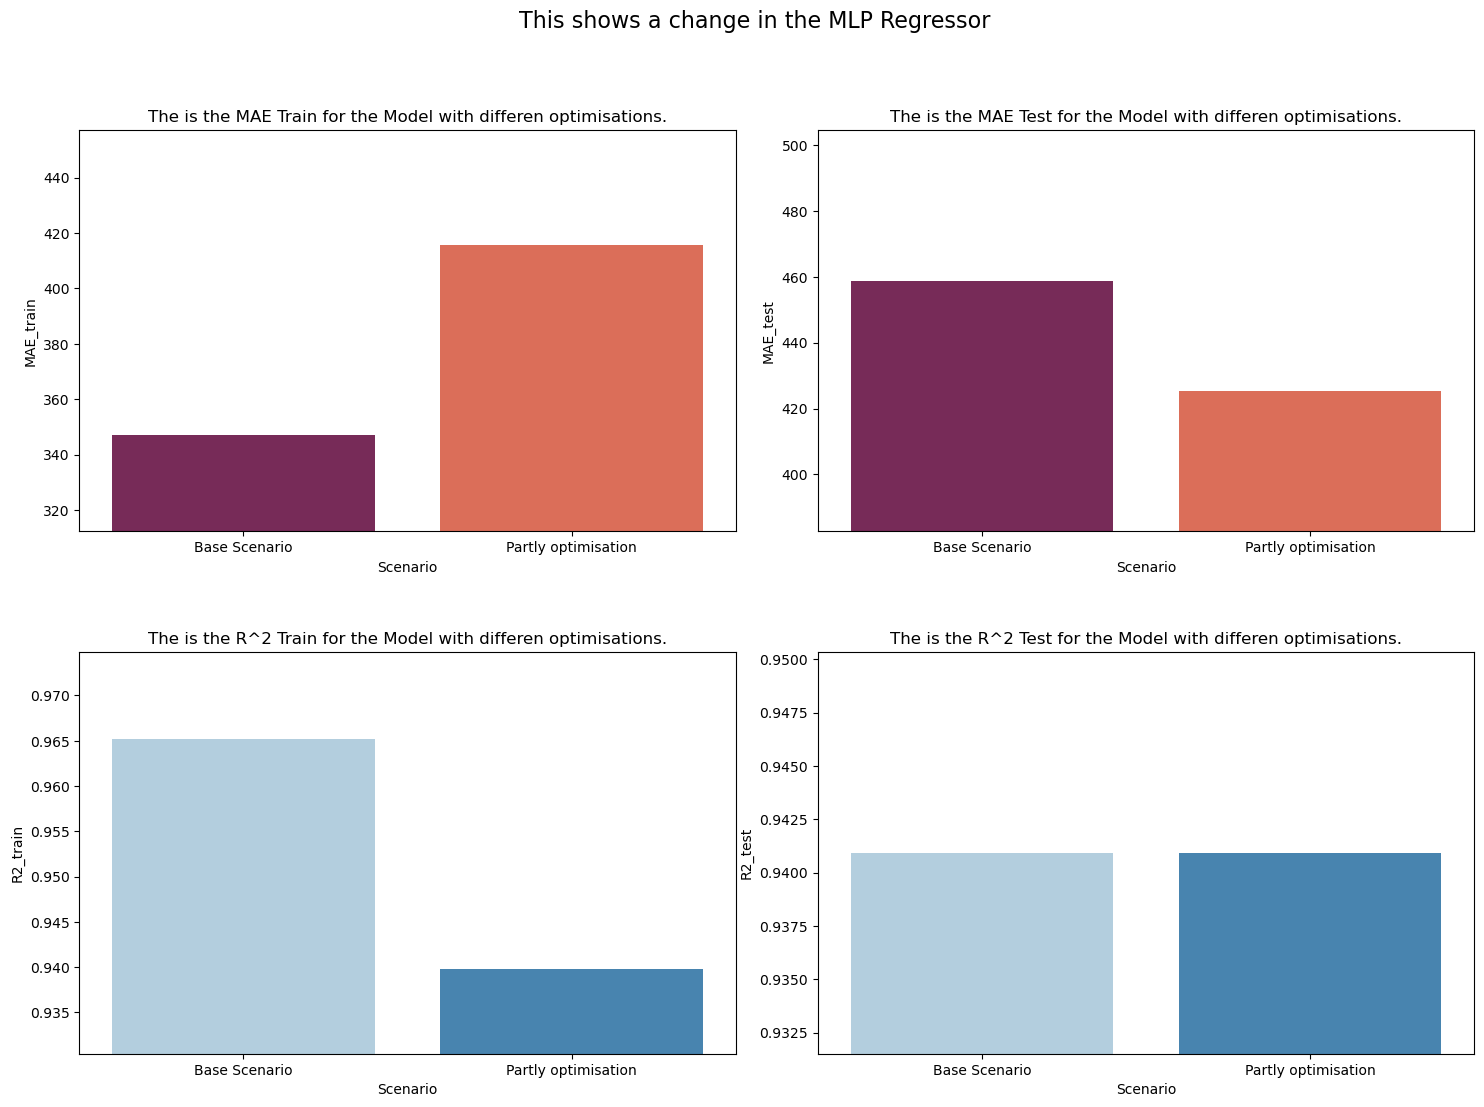

In [ ]:
# plotting a comparison to the base model

plot_bars_comp("MLP Regressor", comparison)

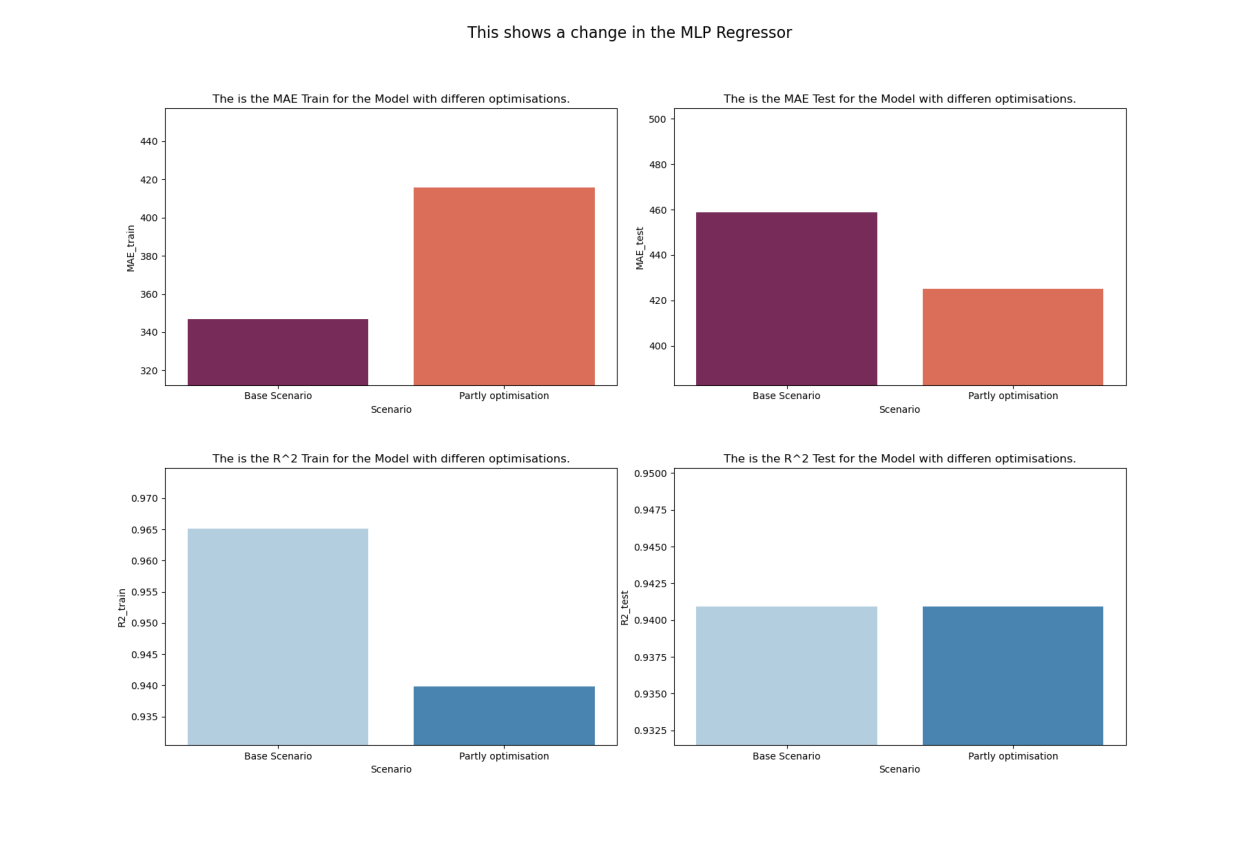

In [ ]:
show_images_compa("MLP Regressor")

# Random Forest

In [3]:
# Importing the data and splitting it into a train and test set to work with
ped = pd.read_csv("data/data_clean_with_dummies.csv", index_col=0)

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

## Hyperparameter Tuning

### 1. Establish Base Scenario

In [4]:
# Initialize a Random Forest with the default parameters 
forest_base = RandomForestRegressor(random_state=144,n_jobs=-1)

In [70]:
# Creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# Defining a function to fit the scenario and evaluate it
def scenario_fit_evaluate(model, display_name, scenario, traindataX, traindatay, testdataX, testdatay):
    global comparison
    # Fit the Model to the train data
    scenario.fit(traindataX, traindatay)

    # Make predictions
    ypred_train = scenario.predict(traindataX)
    ypred = scenario.predict(testdataX)

    # Compute the MAE
    mae_train = mean_absolute_error(traindatay, ypred_train)
    mae_test = mean_absolute_error(testdatay, ypred)
    # Comute R^2
    r2_train = r2_score(traindatay, ypred_train)
    r2_test = r2_score(testdatay, ypred)

    # Adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # Merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [71]:
# Running the function to get the baseline values
scenario_fit_evaluate("Random Forest", "Base Scenario", forest_base, 
    Xtrain, ytrain, Xtest, ytest)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  Random Forest  Base Scenario  148.597666  339.997802  0.988607  0.942855


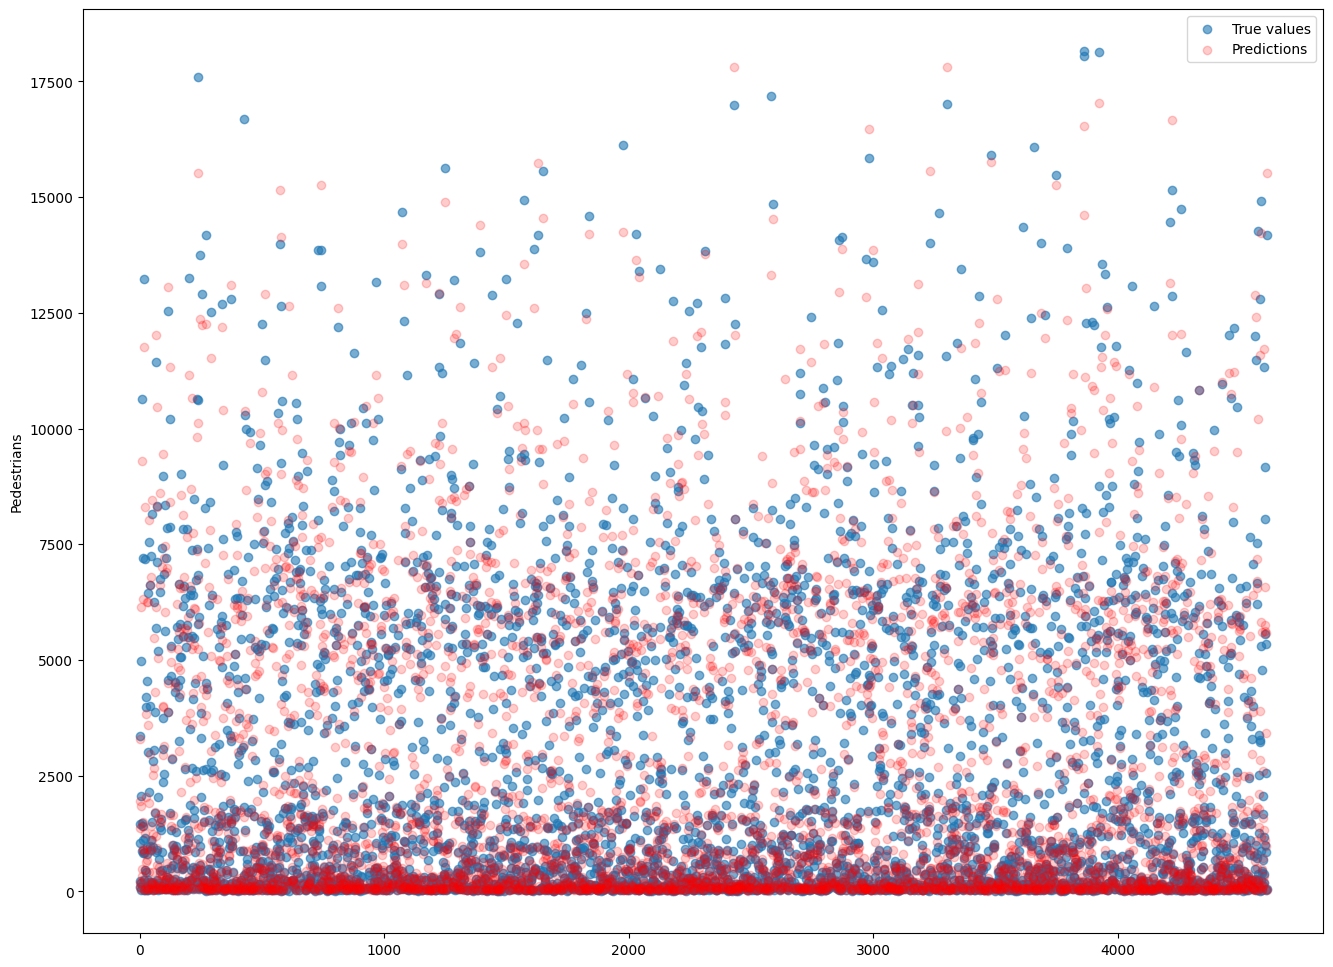

In [7]:
def plot_baseline(model, Xtest, ytest):
    # Plot the results to see the results of our base scenario
    fig, ax = plt.subplots(figsize=(16, 12))

    # Create a linspace to match the y-values
    xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

    # Plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="True values", alpha=0.6)

    # plot the predictions
    ypred = model.predict(Xtest)
    ax.scatter(xs, ypred, label="Predictions", color = "red", alpha=0.2)

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()

# Plot the Predictions and the Actual data for the Test set to get a first impression
plot_baseline(forest_base, Xtest, ytest)

### 2. Analyze the Influence of the Different Parameters

In [37]:
# Conduncting the parameter analysis on the most used parameters for optimization
# n_estimatorsgives how many trees are considered, Defalut = 100
n_estimators = [x for x in range(50, 800, 50)]
# ccp_alpha: is a complexity parameter,  Defalut = 0
ccp_alpha = [x for x in np.linspace(0, 0.3, 30)]
#max_depth:  gives the longest path possible in a tree, Defalut = None
max_depth = [x for x in range(10, 30, 2)]
max_depth2 = [x for x in range(30, 201, 10)]
max_depth.extend(max_depth2)
# max_features: gives the maximum features provided to each tree, Defalut = 1.0
max_features = [x for x in range(1, 41, 2)]
# max_features_deciaml: gives the maximum features provided to each tree (a floater is multiplyed by all features), Defalut = 1.0
max_features_decimal = [x for x in np.linspace(0.01, 1, 20)]
# min_sample_split: is the minimum required number of observations in node to split it, Defalut = 2
min_samples_split = [x for x in range(2, 30, 1)]
# min_samples_leaf: is the minimum number of samples that should be present in the leaf node after splitting, Defalut = 1
min_samples_leaf = [x for x in range(1, 15, 1)]

names_parameters = ["n_estimators","ccp_alpha", "max_depth", "max_features", "max_features_decimal", "min_samples_split", "min_samples_leaf"]

In [11]:
# if True: # Remove the 2 first lines to run the code, this is just a safeguard
#      raise Exception("Remove these two lines first")



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 




# creating a dataframe to save the results
results = pd.DataFrame(columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter(model, param, param_values, initialize_model):
    global results
    for param_value in param_values:
        rf_param = initialize_model(param_value)
        # Fit the network to the train data
        rf_param.fit(Xtrain, ytrain)
        # Make predictions
        ypred_train = rf_param.predict(Xtrain)
        ypred_test = rf_param.predict(Xtest)
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_train)
        mae_param_test = mean_absolute_error(ytest, ypred_test)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_train)
        r2_param_test = r2_score(ytest, ypred_test)

        # Adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[model, param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])



# Apply the function to the different parameters
test_parameter("Random Forest", "n_estimators", n_estimators, lambda value: RandomForestRegressor(n_estimators=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "ccp_alpha", ccp_alpha, lambda value: RandomForestRegressor(ccp_alpha=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "max_depth", max_depth, lambda value: RandomForestRegressor(max_depth=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "max_features", max_features, lambda value: RandomForestRegressor(max_features=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "max_features_decimal", max_features_decimal, lambda value: RandomForestRegressor(max_features=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "min_samples_split", min_samples_split, lambda value: RandomForestRegressor(min_samples_split=value, random_state=144,n_jobs=-1))
test_parameter("Random Forest", "min_samples_leaf", min_samples_leaf, lambda value: RandomForestRegressor(min_samples_leaf=value, random_state=144,n_jobs=-1))

# Merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("data/param_testing.csv", sep=";", index=False)


In [12]:
# Reading the created dataframe
param_testing = pd.read_csv("data/param_testing.csv", sep=";")
param_testing

Model         Parameter  ParameterValue    MaeTrain     MaeTest  \
0    Random Forest      n_estimators            50.0  150.315953  343.126109   
1    Random Forest      n_estimators           100.0  148.597666  339.997802   
2    Random Forest      n_estimators           150.0  147.903962  339.946154   
3    Random Forest      n_estimators           200.0  147.425144  339.689687   
4    Random Forest      n_estimators           250.0  147.290344  339.148249   
..             ...               ...             ...         ...         ...   
150  Random Forest  min_samples_leaf            10.0  284.544002  347.151226   
151  Random Forest  min_samples_leaf            11.0  292.791413  350.538274   
152  Random Forest  min_samples_leaf            12.0  301.044805  352.928233   
153  Random Forest  min_samples_leaf            13.0  308.946606  356.254858   
154  Random Forest  min_samples_leaf            14.0  316.147794  359.280627   

      R2Train    R2Test  
0    0.988356  0.942214  
1    0.988607  0.942855  
2    0.988755  0.943692  
3    0.988879  0.943672  
4    0.988901  0.944100  
..        ...       ...  
150  0.959990  0.941279  
151  0.957818  0.940292  
152  0.955668  0.939867  
153  0.953592  0.939040  
154  0.951684  0.938404  

[155 rows x 7 columns]

C:\Users\Biebert\AppData\Local\Temp\ipykernel_18900\2380771373.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["MaeTrain_std"] = standardize_df_col(plot_data["MaeTrain"])
C:\Users\Biebert\AppData\Local\Temp\ipykernel_18900\2380771373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["MaeTest_std"] = standardize_df_col(plot_data["MaeTest"])
C:\Users\Biebert\AppData\Local\Temp\ipykernel_18900\2380771373.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

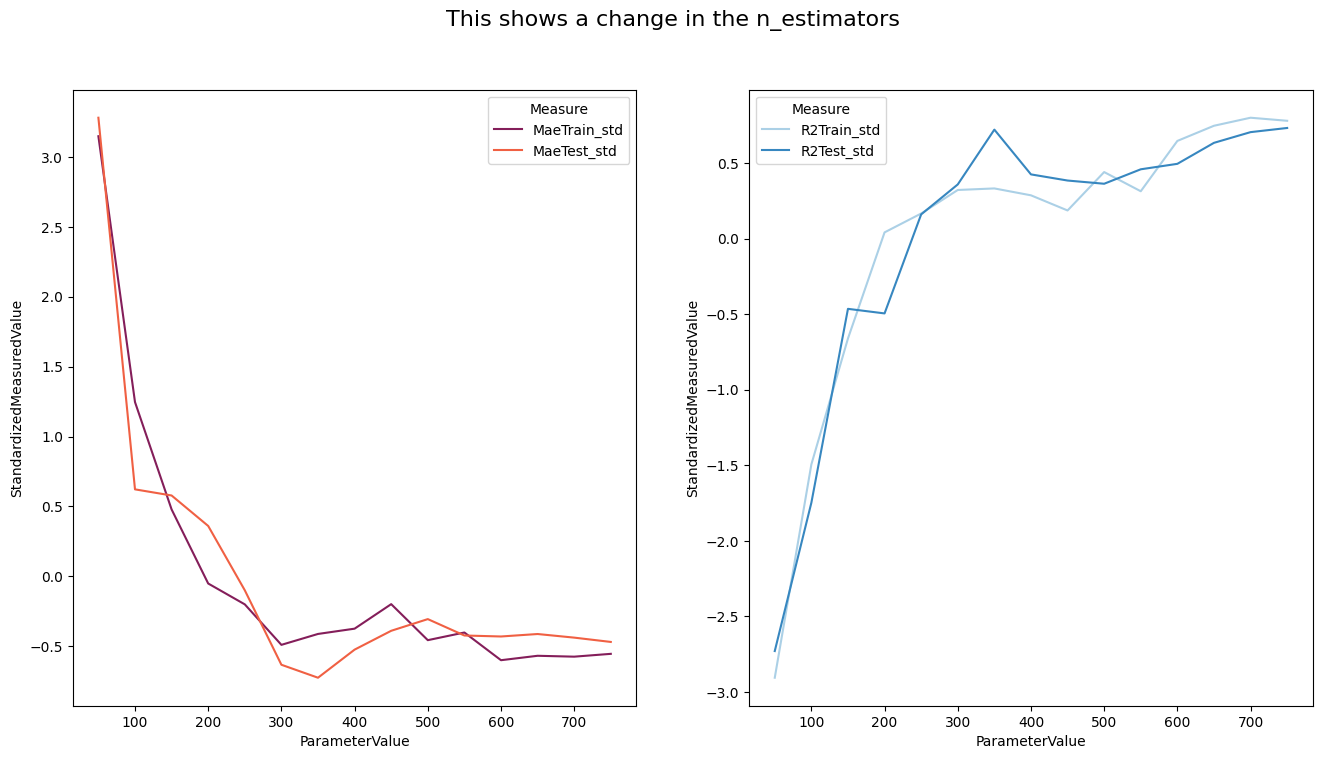

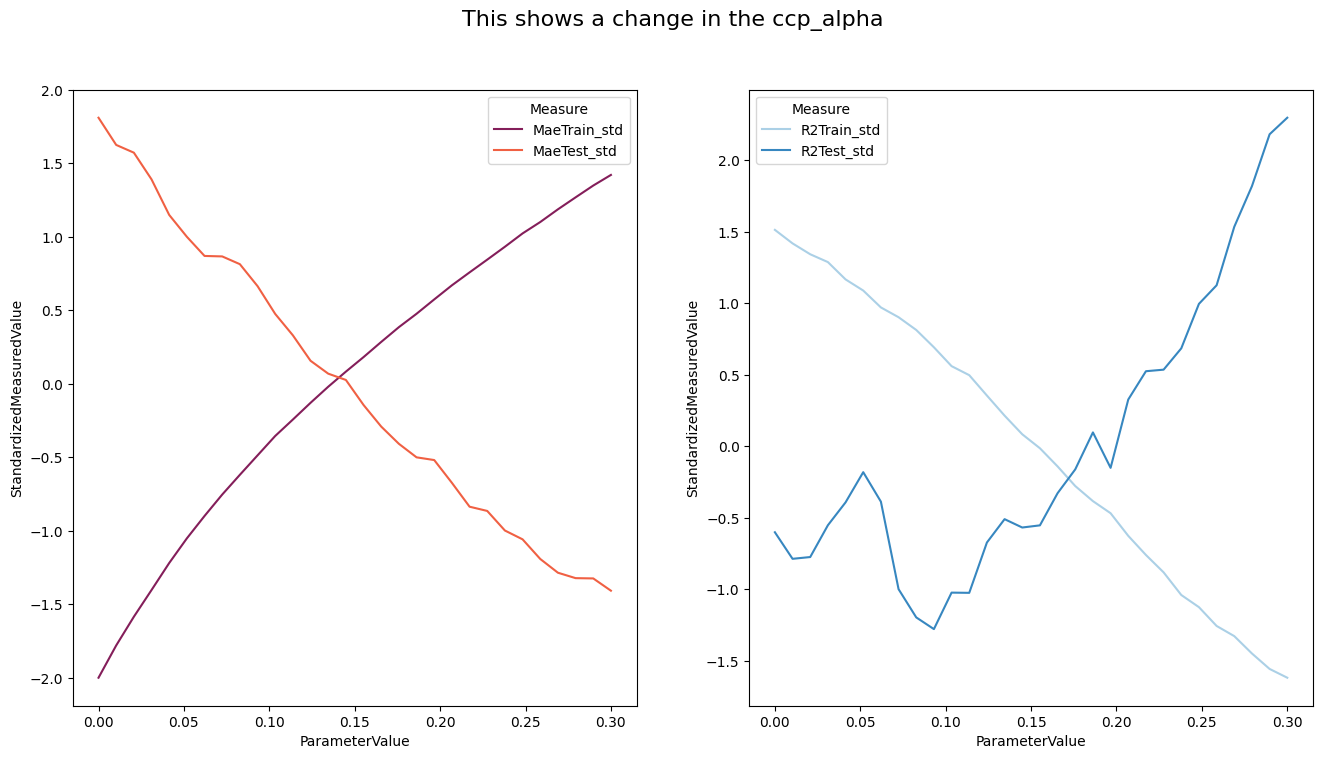

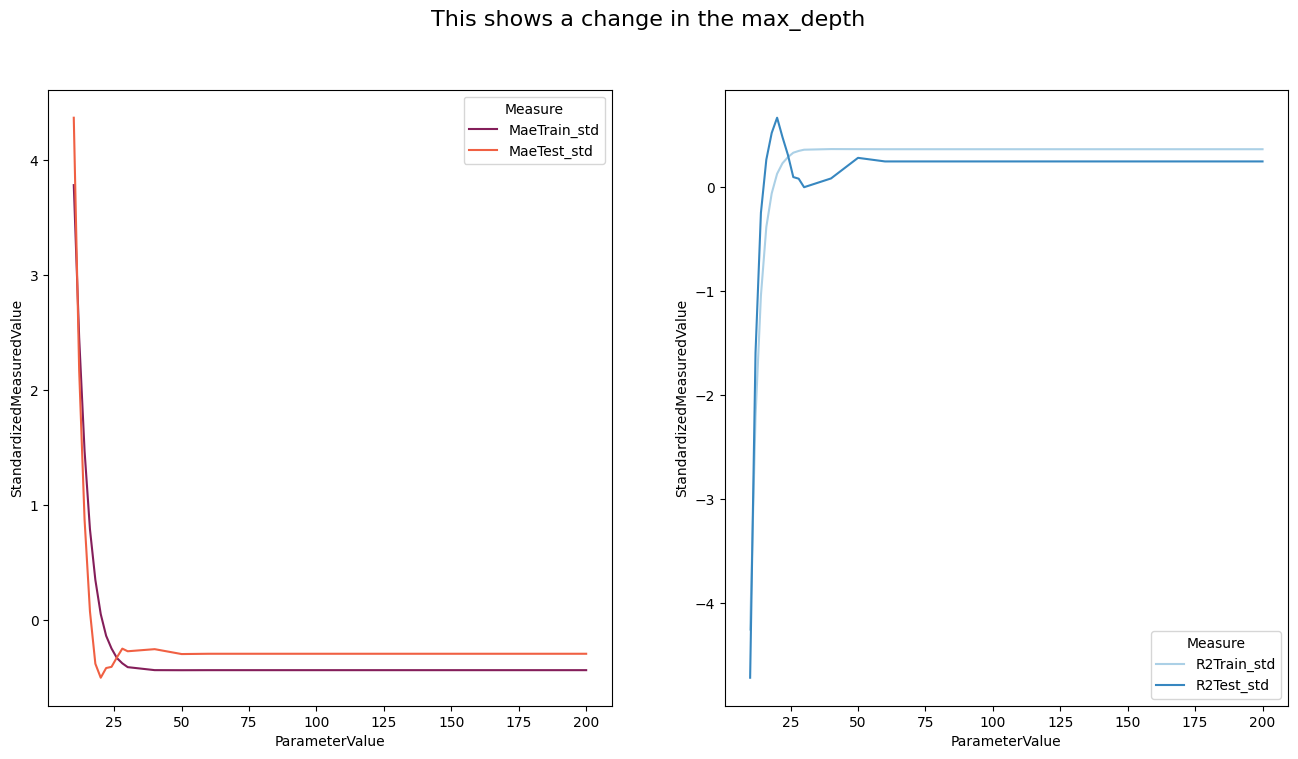

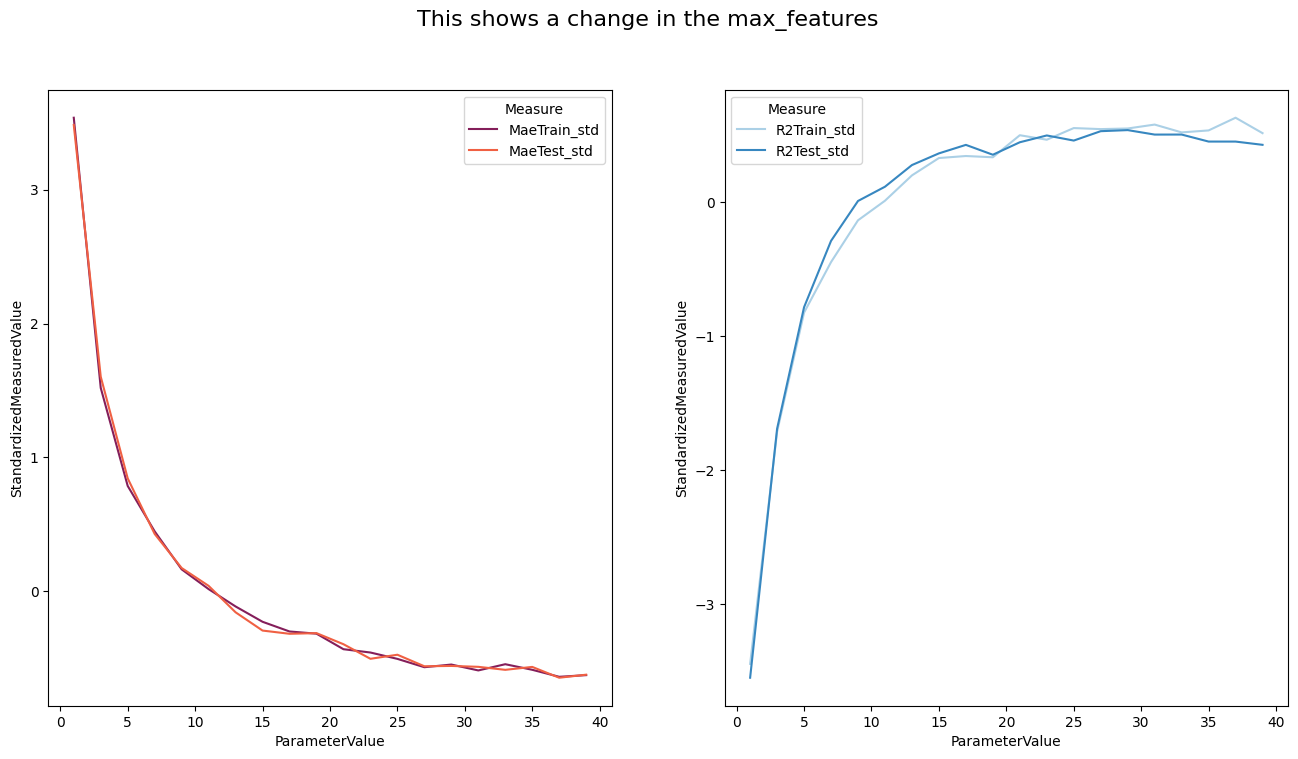

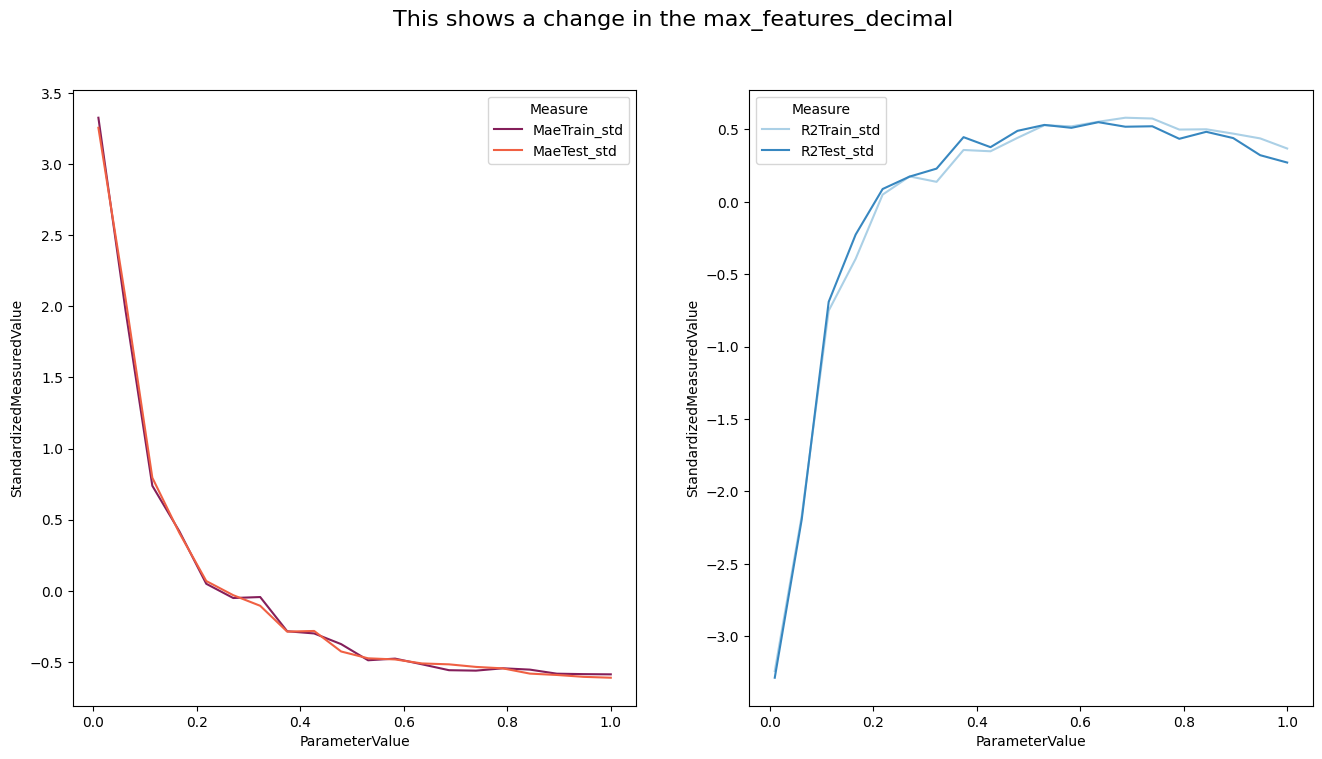

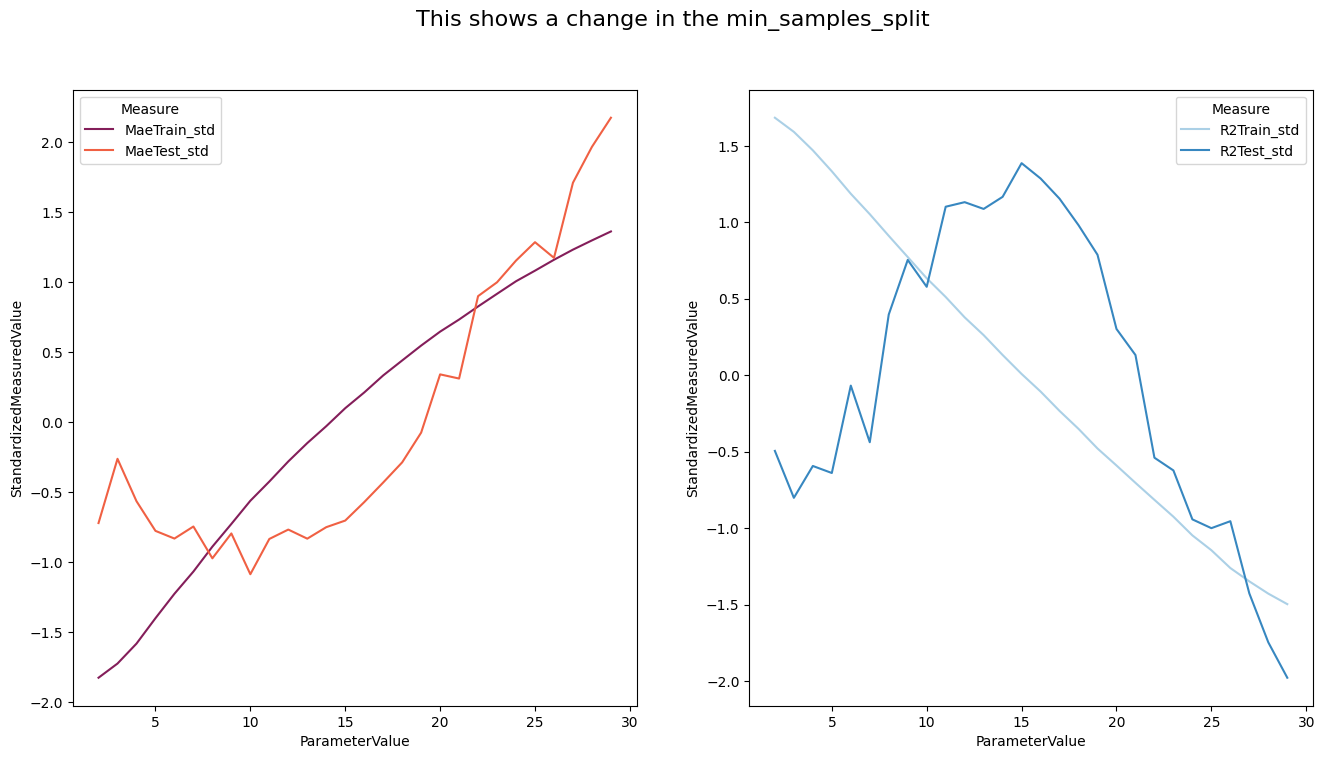

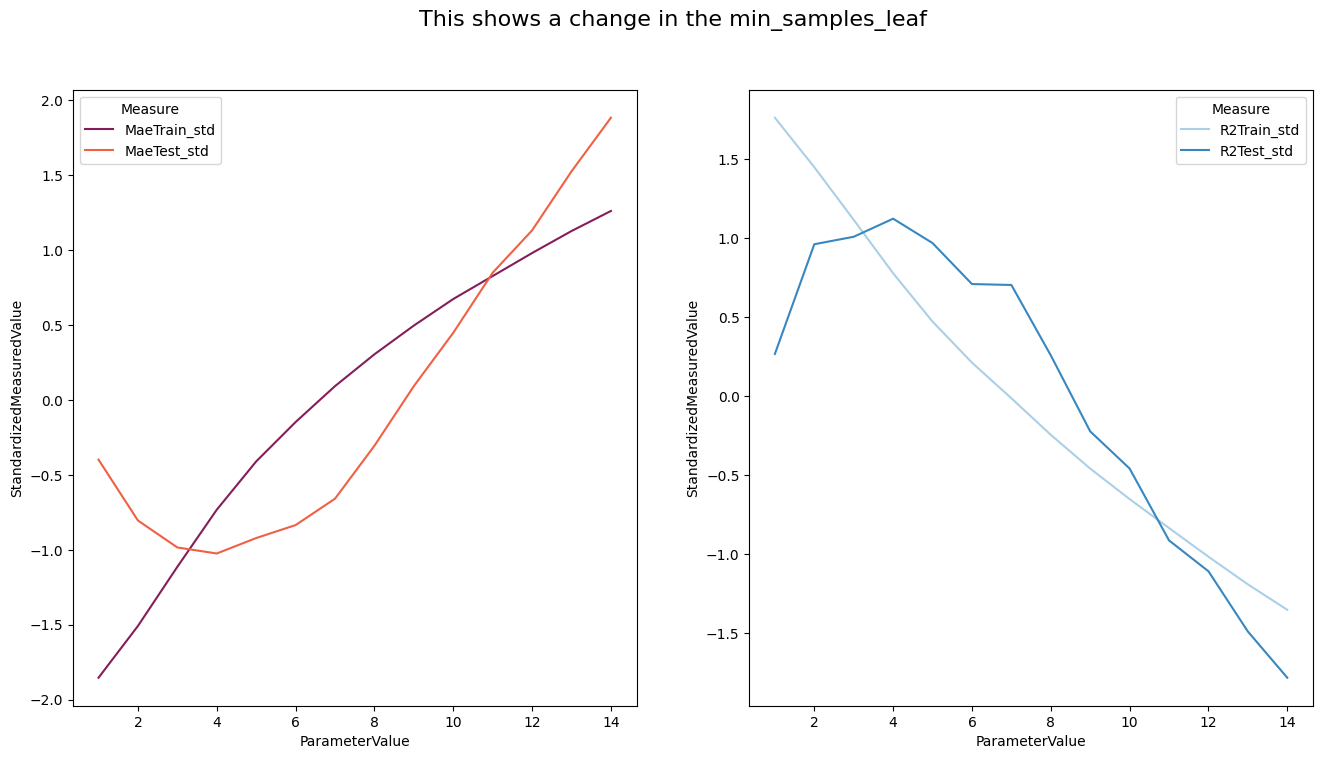

In [32]:
# Defining a function for standardization to have a better look at the change of the parameters
standardize_df_col = lambda df_c: (df_c - df_c.mean()) / df_c.std()

# Defining a function for lineplots for the parameters to compare mae and r2 for test and train data
def plot_lines(data_filter_model, data_filter_parameter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    # Filter the dataframe for the wanted Model and the wanted Parameter
    plot_data_all_param = param_testing[param_testing["Model"] == data_filter_model]
    plot_data = plot_data_all_param[plot_data_all_param["Parameter"] == data_filter_parameter]

    # Standardize the Values to see changes better and name them accordingly in new columns
    plot_data["MaeTrain_std"] = standardize_df_col(plot_data["MaeTrain"])
    plot_data["MaeTest_std"] = standardize_df_col(plot_data["MaeTest"])
    plot_data["R2Train_std"] = standardize_df_col(plot_data["R2Train"])
    plot_data["R2Test_std"] = standardize_df_col(plot_data["R2Test"])

    # Bring the data into a long format to plot them
    plot_data_std = pd.melt(plot_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain_std", "MaeTest_std", "R2Train_std", "R2Test_std"], value_name="StandardizedMeasuredValue")

    # Select the standadised mae data and plot them 
    mae_data = plot_data_std[plot_data_std["Measure"].isin(["MaeTrain_std", "MaeTest_std"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    #mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data_std[plot_data_std["Measure"].isin(["R2Train_std", "R2Test_std"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    #r2_axes.set_xticks([0, 24, 49])

    fig.suptitle(f"This shows a change in the {data_filter_parameter}", fontsize=16)
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.savefig(f"plots/{data_filter_model}_{data_filter_parameter}.png")

# apply the function to wanted parameters for comparison
plot_lines("Random Forest", "n_estimators")
plot_lines("Random Forest", "ccp_alpha")
plot_lines("Random Forest", "max_depth")
plot_lines("Random Forest", "max_features")
plot_lines("Random Forest", "max_features_decimal")
plot_lines("Random Forest", "min_samples_split")
plot_lines("Random Forest", "min_samples_leaf")

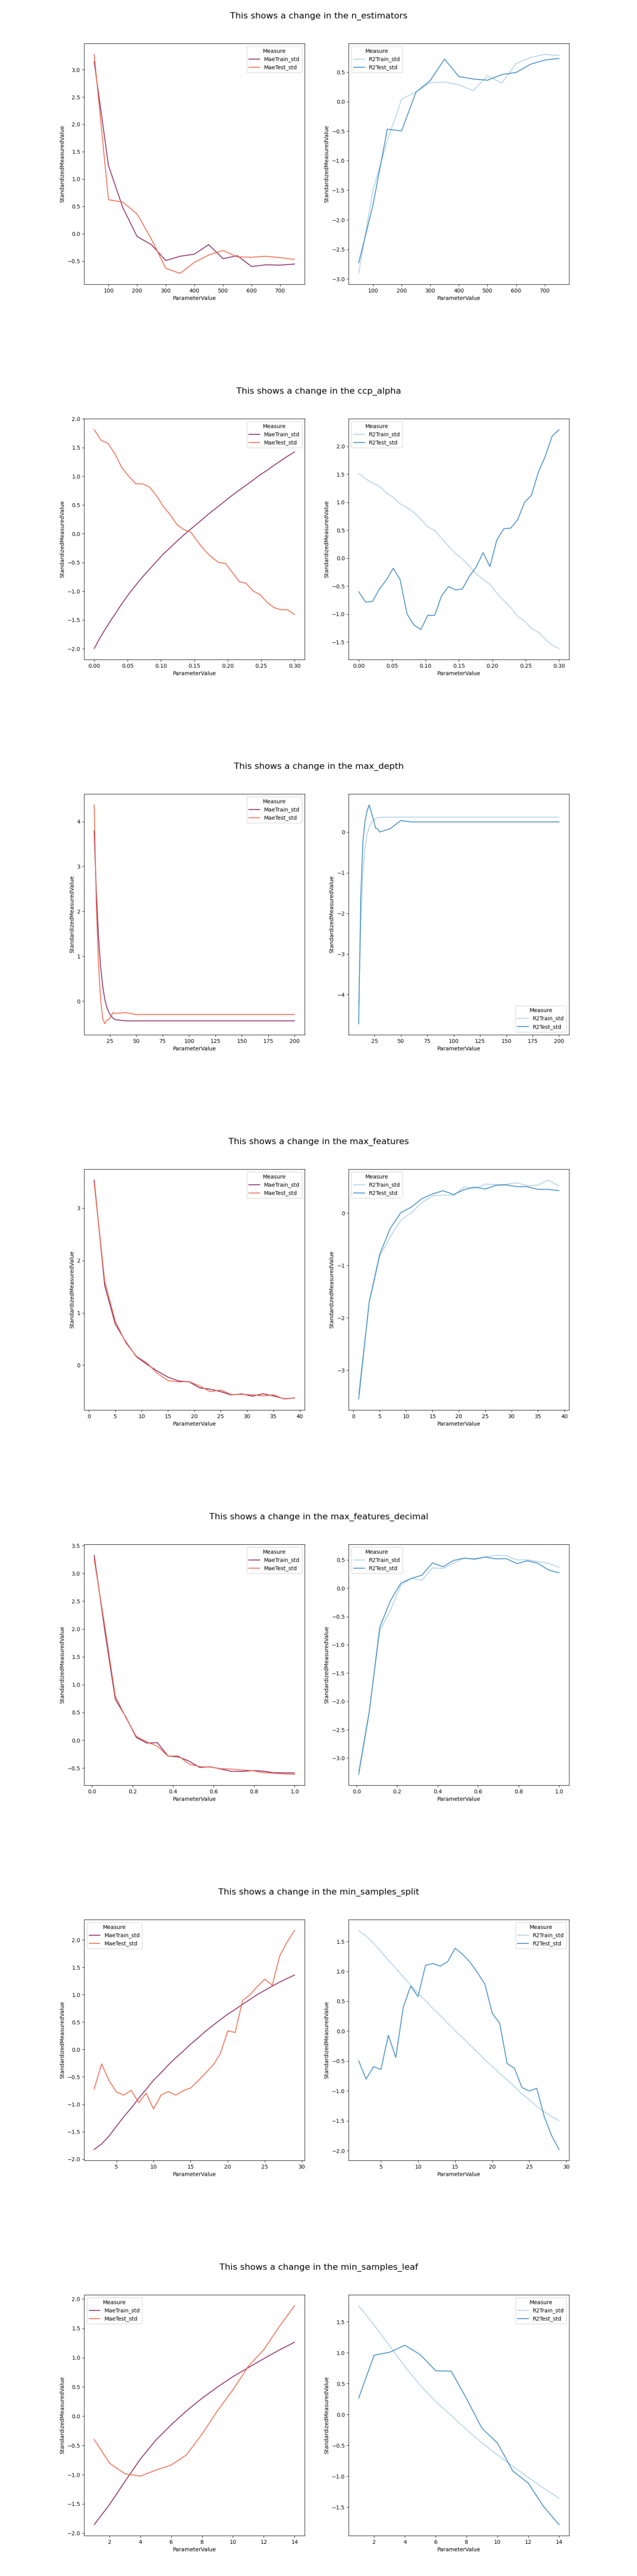

In [43]:
# Define a function to create figure frome saved pictures
def show_images_parameter(model, parameter_list):
    fig = plt.figure(figsize=(16, 8*len(parameter_list)))
    
    # Set the row and column number
    columns = 1
    rows = (len(parameter_list))
    
    # Go throug all parameters of the model
    i = 1
    for parameter in parameter_list:
        # Reading images
        img = Image.open(f"plots/{model}_{parameter}_rf.png")
        # Adds a subplot at the i position
        fig.add_subplot(rows, columns, i)
        i += 1
        # Showing the Image
        plt.imshow(img)
        plt.axis('off')
    fig.savefig(f"plots/all_parameter_of_{model}.png")

    

show_images_parameter("Random Forest", names_parameters)



### 3. Optimize the Hyperparameters with the Findings above

In [46]:
# Subsetting the data for the optimization of the hyperparameters
ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X of the subset with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

# Subset of the output to predict
y_subset = ped_subset["pedestrians count"]

# Split the subset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)

In [72]:
# Definint a Base Model for the Subset
forest_base_sub = RandomForestRegressor(random_state=144,n_jobs=-1)
forest_base_sub.fit(Xtrain_subset, ytrain_subset)

# Evaluate the basemodel for the Subset
scenario_fit_evaluate("Random Forest Subset", "Base Scenario", forest_base_sub, 
    Xtrain_subset, ytrain_subset, Xtest_subset, ytest_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         Random Forest  Base Scenario  148.597666  339.997802  0.988607   
1  Random Forest Subset  Base Scenario  196.444005  571.199575  0.984530   

    R2_test  
0  0.942855  
1  0.897685  


In [17]:
# Setting up the parameter that should be tuned, orientated at the visualisation above
n_estimators = [x for x in range(300, 601, 50)]
ccp_alpha = [x for x in np.linspace(0.0, 0.2, 10)]
max_depth = [int(x) for x in range(5, 30, 5)]
max_depth.append(None)
max_features = [x for x in np.linspace(0.0, 1, 5)]
max_features.extend([None])
min_samples_split = [int(x) for x in range(5, 20, 5)]
min_samples_leaf = [x for x in range(1, 8, 2)]
bootstrap = [True, False]

# Create the param grid
param_distributions = {"n_estimators": n_estimators,
               "ccp_alpha": ccp_alpha,
               "max_depth": max_depth,
               "max_features": max_features,
               "min_samples_leaf": min_samples_leaf,
               "min_samples_split":min_samples_split,
               "bootstrap": bootstrap
            }

# In total 60480 possibileties
length = [len(values) for key, values in param_distributions.items()]
print(f"In total we have {np.prod(length)} possibleties")
#
# Print Results: In total we have 60480 possibleties
#


In total we have 60480 possibleties


In [18]:
# Set up a Forest for the Optimisation
forest = RandomForestRegressor(random_state=144)

# Run grid search cross validation
random_search_forest_subset = RandomizedSearchCV(estimator = forest, param_distributions = param_distributions, verbose=2,n_iter = 5000, n_jobs = -1, cv = 4)
random_search_forest_subset.fit(Xtrain_subset, ytrain_subset)
# Finding out best parameteers
print(random_search_forest_subset.best_params_)
#
# Print Results: {'bootstrap': False,
#                   'ccp_alpha': 0.2,
#                   'max_depth': 25,
#                   'max_features': 0.75,
#                   'min_samples_leaf': 5,
#                   'min_samples_split': 15,
#                   'n_estimators': 500}
#


Fitting 4 folds for each of 5000 candidates, totalling 20000 fits


c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3552 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1780 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator)

{'n_estimators': 450, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20, 'ccp_alpha': 0.2, 'bootstrap': False}


In [73]:
# Creating a Random Forest with the results of the RandomSearchCV and the subset to look at the mae and r2
forest_random =RandomForestRegressor(random_state=144, n_jobs = -1, n_estimators= 500, min_samples_split= 15, min_samples_leaf = 5, max_features = 0.75, 
                                                max_depth= 25, ccp_alpha =0.2, bootstrap= False)

# fit the data and run the model with new parameters
scenario_fit_evaluate("Random Forest Subset", "RandomSearch", forest_random, Xtrain_subset, ytrain_subset, Xtest_subset, ytest_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         Random Forest  Base Scenario  148.597666  339.997802  0.988607   
1  Random Forest Subset  Base Scenario  196.444005  571.199575  0.984530   
2  Random Forest Subset   RandomSearch  238.349159  588.154607  0.972960   

    R2_test  
0  0.942855  
1  0.897685  
2  0.890751  


### More Specific with GridSearchCV

In [20]:
# Set up a GridSearch to further optimize our Model orientated at the Random Search and the base model, since that was better than the search.
# But due to the limited capacity, we can not calculate more possibility in RandomSearch and fore some reasons Grid search as well
# Randomized was 500
n_estimators = [550,500]
# Randomized was 0.2 (upper bound)
ccp_alpha = [0.3, 0.2]
#Randomized was 25
max_depth = [25, None]
# Randomized was 0.75
max_features = [0.75, None]
# Randomized was 15
min_samples_split = [15, 2]
# Randomized was 5
min_samples_leaf = [5, 1]
# Randomized was False
bootstrap = [False, True]

# Create the param grid
param_distributions = {"n_estimators": n_estimators,
               "ccp_alpha": ccp_alpha,
               "max_depth": max_depth,
               "max_features": max_features,
               "min_samples_leaf": min_samples_leaf,
               "min_samples_split":min_samples_split,
               "bootstrap": bootstrap
            }

# In total possibileties
length = [len(values) for key, values in param_distributions.items()]
print(f"In total we have {np.prod(length)} possibleties")
#
# Print Results: In total we have 128 possibleties
#

In total we have 128 possibleties


In [21]:
# Set up a Forest for the Optimisation
forest = RandomForestRegressor(random_state=144)

# Run GridSearchCV on the subset of the data
grid_search_forest_subset = GridSearchCV(estimator = forest, param_grid = param_distributions, verbose=2, n_jobs = -1, cv = 5)
grid_search_forest_subset.fit(Xtrain_subset, ytrain_subset)
# Finding out best parameteers
print(grid_search_forest_subset.best_params_)
#
# Print Results: {'bootstrap': True,
#                   'ccp_alpha': 0.2,
#                   'max_depth': None,
#                   'max_features': None,
#                   'min_samples_leaf': 1,
#                   'min_samples_split': 2,
#                   'n_estimators': 550}
#

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'bootstrap': True, 'ccp_alpha': 0.2, 'max_depth': None, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550}


In [74]:
# creating a random forest with the results of GridSearchCV and the subset to look at the mae and r2
forest_grid =RandomForestRegressor(random_state=144, n_jobs = -1, n_estimators= 550, min_samples_split= 2, min_samples_leaf = 1, 
                                        max_features = None, max_depth= None, ccp_alpha =0.2, bootstrap= True)

# fit the data and run the model with new parameters
scenario_fit_evaluate("Random Forest Subset", "GridSearch", forest_grid, Xtrain_subset, ytrain_subset, Xtest_subset, ytest_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         Random Forest  Base Scenario  148.597666  339.997802  0.988607   
1  Random Forest Subset  Base Scenario  196.444005  571.199575  0.984530   
2  Random Forest Subset   RandomSearch  238.349159  588.154607  0.972960   
3  Random Forest Subset     GridSearch  192.292330  563.034369  0.984763   

    R2_test  
0  0.942855  
1  0.897685  
2  0.890751  
3  0.900035  


## Comparing the results of the 3 neural networks

In [23]:
# reading the created dataframe and have a look at it to plot it later for the analysis
comparison = pd.read_csv("comparison_mae_r2.csv", sep=";")
comparison

Model       Scenario   MAE_train    MAE_test  R2_train  \
0         Random Forest  Base Scenario  148.597666  339.997802  0.988607   
1  Random Forest Subset  Base Scenario  196.444005  571.199575  0.984530   
2  Random Forest Subset   RandomSearch  238.349159  588.154607  0.972960   
3  Random Forest Subset     GridSearch  238.349159  588.154607  0.972960   

    R2_test  
0  0.942855  
1  0.897685  
2  0.890751  
3  0.890751

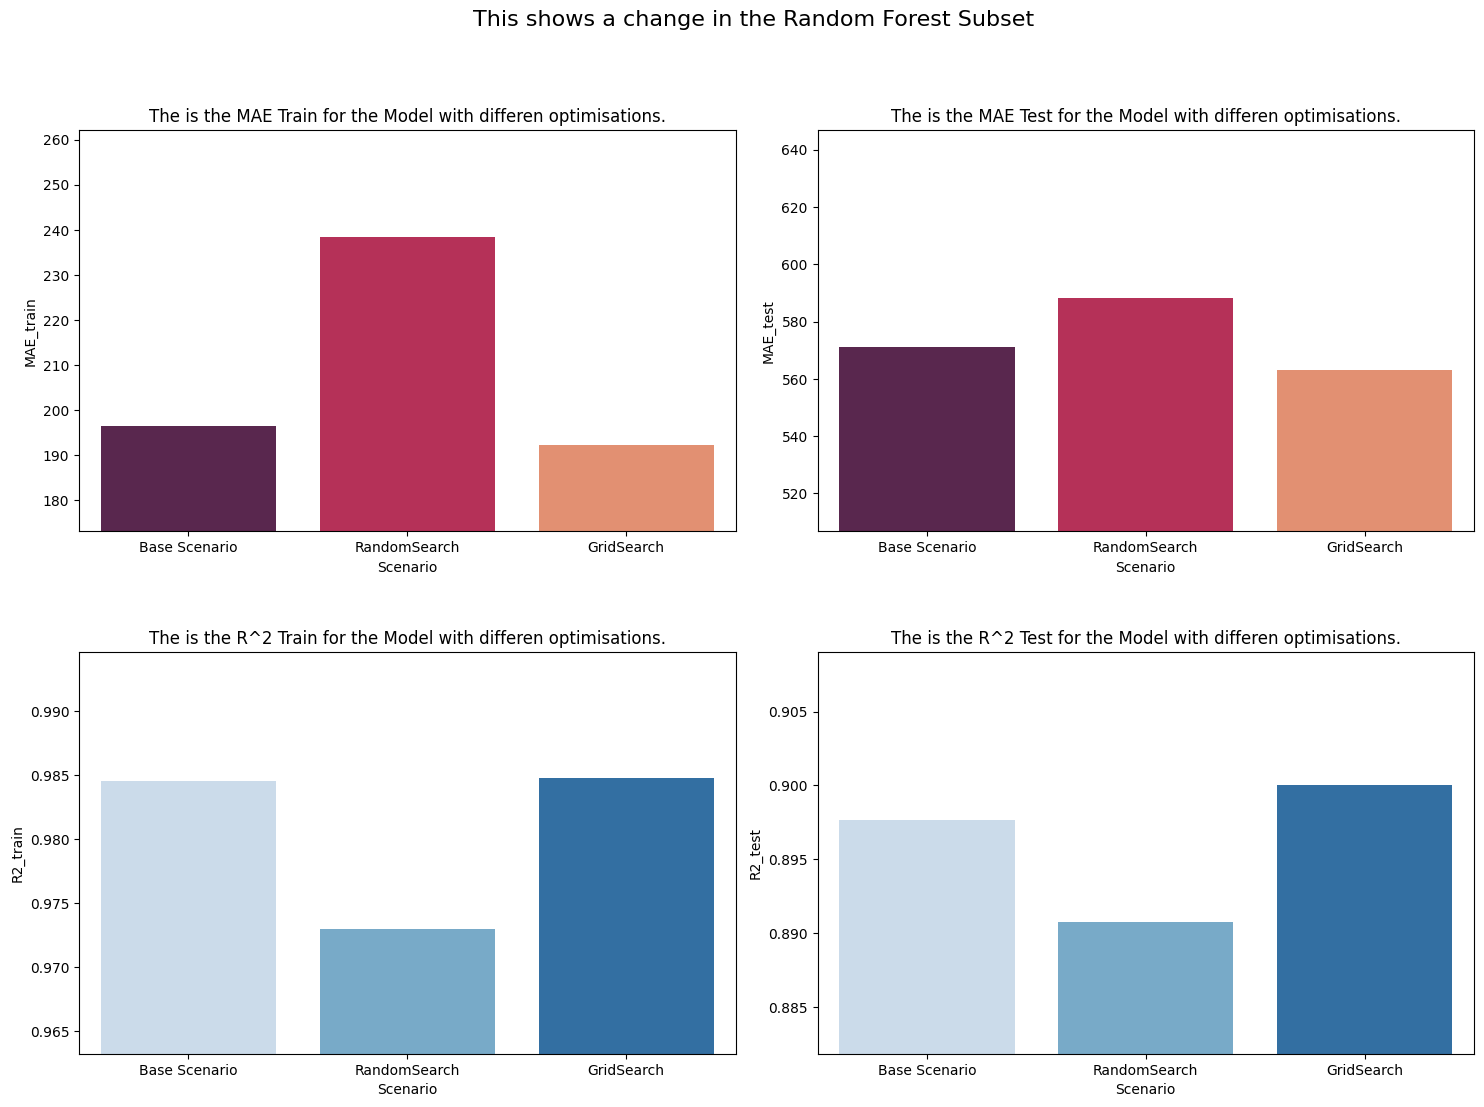

In [75]:
# Define a Function to plot the comparison of the models
def plot_bars_comp(model, dataframe):
    # Define the dimensions and model of the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_data = dataframe[dataframe["Model"] == model]

    # Get the MAE train bars
    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim((plot_data["MAE_train"].min())*0.9, (plot_data["MAE_train"].max())*1.1)
    mae_train_axes.set_title(f"The is the MAE Train for the Model with differen optimisations.")

    # Get the MAE test bars
    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim((plot_data["MAE_test"].min())*0.9, (plot_data["MAE_test"].max())*1.1)
    mae_test_axes.set_title(f"The is the MAE Test for the Model with differen optimisations.")


    # Get the r2 train bars
    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim((plot_data["R2_train"].min())*0.99, (plot_data["R2_train"].max())*1.01)
    r2_train_axes.set_title(f"The is the R^2 Train for the Model with differen optimisations.")


    # Get the r2 test bars
    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim((plot_data["R2_test"].min())*0.99, (plot_data["R2_test"].max())*1.01)
    r2_test_axes.set_title(f"The is the R^2 Test for the Model with differen optimisations.")

    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    # Set a Titel
    fig.suptitle(f"This shows a change in the {model}", fontsize=16)
    fig.savefig(f"plots/{model} comparison_rf.png")


plot_bars_comp("Random Forest Subset", comparison)


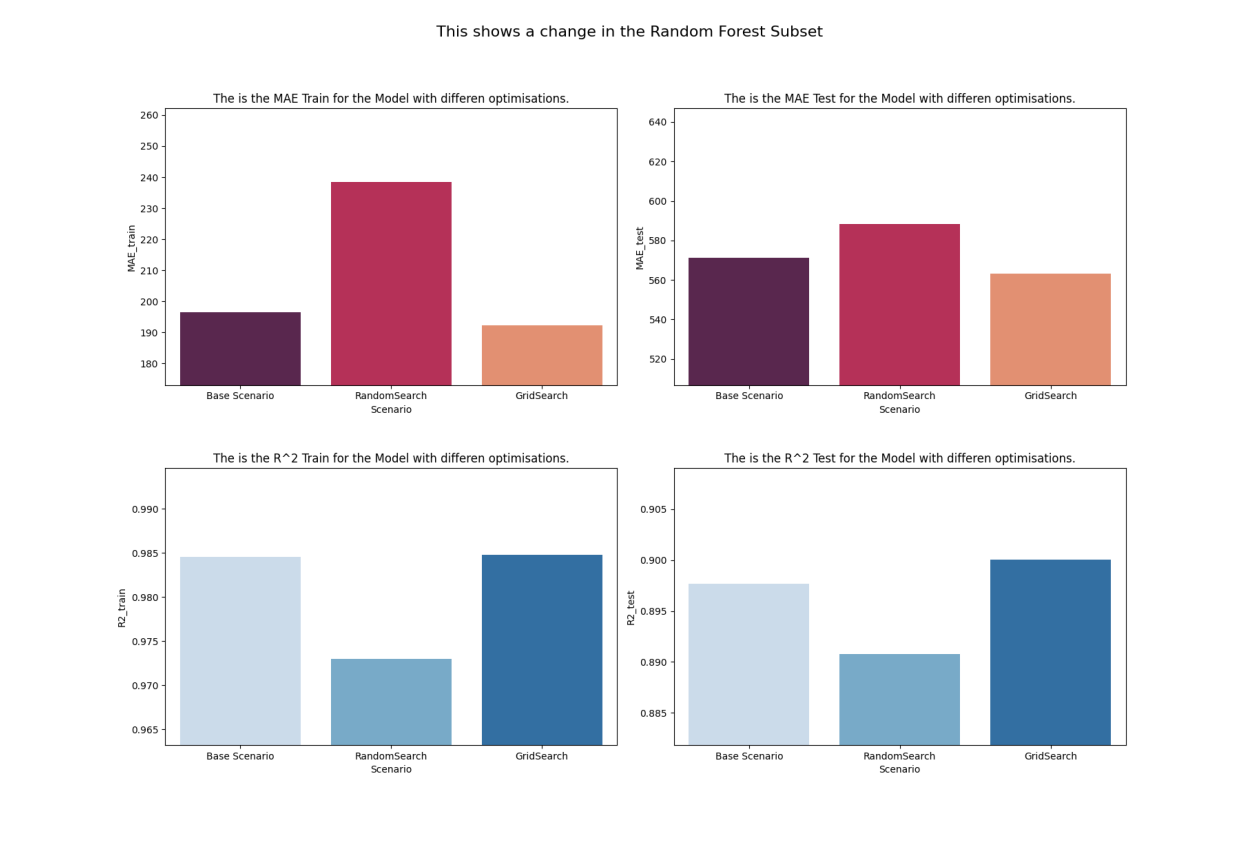

In [76]:
# Define a function to create figure frome saved pictures of the comaprison
def show_images_compa(model):
    fig = plt.figure(figsize=(16, 20))
    
    # Set the row and column number
    rows = 1
    columns = 1


    img = Image.open(f"plots/{model} comparison_rf.png")
    # Adds a subplot at the i position
    fig.add_subplot(rows, columns, 1)

    # Showing the Image
    plt.imshow(img)
    plt.axis('off')
    

show_images_compa("Random Forest Subset")

### Optimisation for the whole Dataset

In [26]:
# Setting up the first Hyperparameters that should be tuned, due to the size of the Dataset only very few
# Number of trees in random forest
n_estimators = [int(x) for x in range(100, 501, 50)]
# Number of features to consider at every split
max_features = [0.25, 0.5, 1.0, None]
# Method to controll complexity 
ccp_alpha = [0, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "ccp_alpha": ccp_alpha}

param_standard = {"n_estimators": 100,
               "max_features": 1.0,
               "ccp_alpha": 0}



In [27]:
# Although they are influencing each other, this is too much for my Comuter, a proper optimization is shown below with a 
# subset and Cross validation takes too much computing power, due to the lage data:

def optimize_parameter(parameter, param_values, param_values_fix1, param_valuesfix_2, Xtest, ytest, initialize_model):
    for param_value in param_values:
        mae_test = []

        rf_param = initialize_model(param_value, param_values_fix1, param_valuesfix_2)
        # Fit the network to the train data
        rf_param.fit(Xtrain, ytrain)
        # Make predictions
        ypred_test = rf_param.predict(Xtest)

        # Compute the MAE
        mae_param_test = mean_absolute_error(ytest, ypred_test)


        # adding them in a list
        mae_test.append(mae_param_test)

    # getting the minimum values
    index_best = np.argmin(mae_test)
    best_parameter = param_values[index_best]

    return best_parameter


best_n_estimator = optimize_parameter("n_estimators", n_estimators, 1.0 , 0,  Xtest, ytest,
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value, max_features=value_fix1, ccp_alpha=value_fix2, random_state=144,n_jobs=-1))

best_max_feat = optimize_parameter("max_features", max_features, best_n_estimator, 0,  Xtest, ytest,
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value_fix1, max_features=value, ccp_alpha=value_fix2, random_state=144,n_jobs=-1))

best_ccp = optimize_parameter("ccp_alpha", ccp_alpha, best_n_estimator, best_max_feat,  Xtest, ytest,
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value_fix1, max_features=value_fix2, ccp_alpha=value, random_state=144,n_jobs=-1))

print(f"The best MAE Test is given with, n_estimators: {best_n_estimator}, max_features: {best_max_feat}, ccp_alpha: {best_ccp}")
#
# Printing Result: The best MAE Test is given with, n_estimators: 350, max_features: 1.0, ccp_alpha: 0.3
#

The best MAE Test is given with, n_estimators: 100, max_features: 0.25, ccp_alpha: 0


In [77]:
# creating a random forest with the results of GridSearchCV and the subset to look at the mae and r2
forest_partly =RandomForestRegressor(random_state=144, n_jobs = -1, n_estimators= 350, max_features = 1.0, ccp_alpha =0.3)

# fit the data and run the model with new parameters
scenario_fit_evaluate("Random Forest", "Partly optimisation", forest_partly, Xtrain, ytrain, Xtest, ytest)

                  Model             Scenario   MAE_train    MAE_test  \
0         Random Forest        Base Scenario  148.597666  339.997802   
1  Random Forest Subset        Base Scenario  196.444005  571.199575   
2  Random Forest Subset         RandomSearch  238.349159  588.154607   
3  Random Forest Subset           GridSearch  192.292330  563.034369   
4         Random Forest  Partly optimisation  148.602726  338.188603   

   R2_train   R2_test  
0  0.988607  0.942855  
1  0.984530  0.897685  
2  0.972960  0.890751  
3  0.984763  0.900035  
4  0.988923  0.944472  


In [80]:
forest_grid =RandomForestRegressor(random_state=144, n_jobs = -1, n_estimators= 550, min_samples_split= 2, min_samples_leaf = 1, 
                                        max_features = None, max_depth= None, ccp_alpha =0.2, bootstrap= True)

# fit the data and run the model with new parameters
scenario_fit_evaluate("Random Forest", "Subset optimized", forest_grid, Xtrain, ytrain, Xtest, ytest)

                  Model             Scenario   MAE_train    MAE_test  \
0         Random Forest        Base Scenario  148.597666  339.997802   
1  Random Forest Subset        Base Scenario  196.444005  571.199575   
2  Random Forest Subset         RandomSearch  238.349159  588.154607   
3  Random Forest Subset           GridSearch  192.292330  563.034369   
4         Random Forest  Partly optimisation  148.602726  338.188603   
5         Random Forest     Subset optimized  148.252711  338.585548   

   R2_train   R2_test  
0  0.988607  0.942855  
1  0.984530  0.897685  
2  0.972960  0.890751  
3  0.984763  0.900035  
4  0.988923  0.944472  
5  0.988922  0.944298  


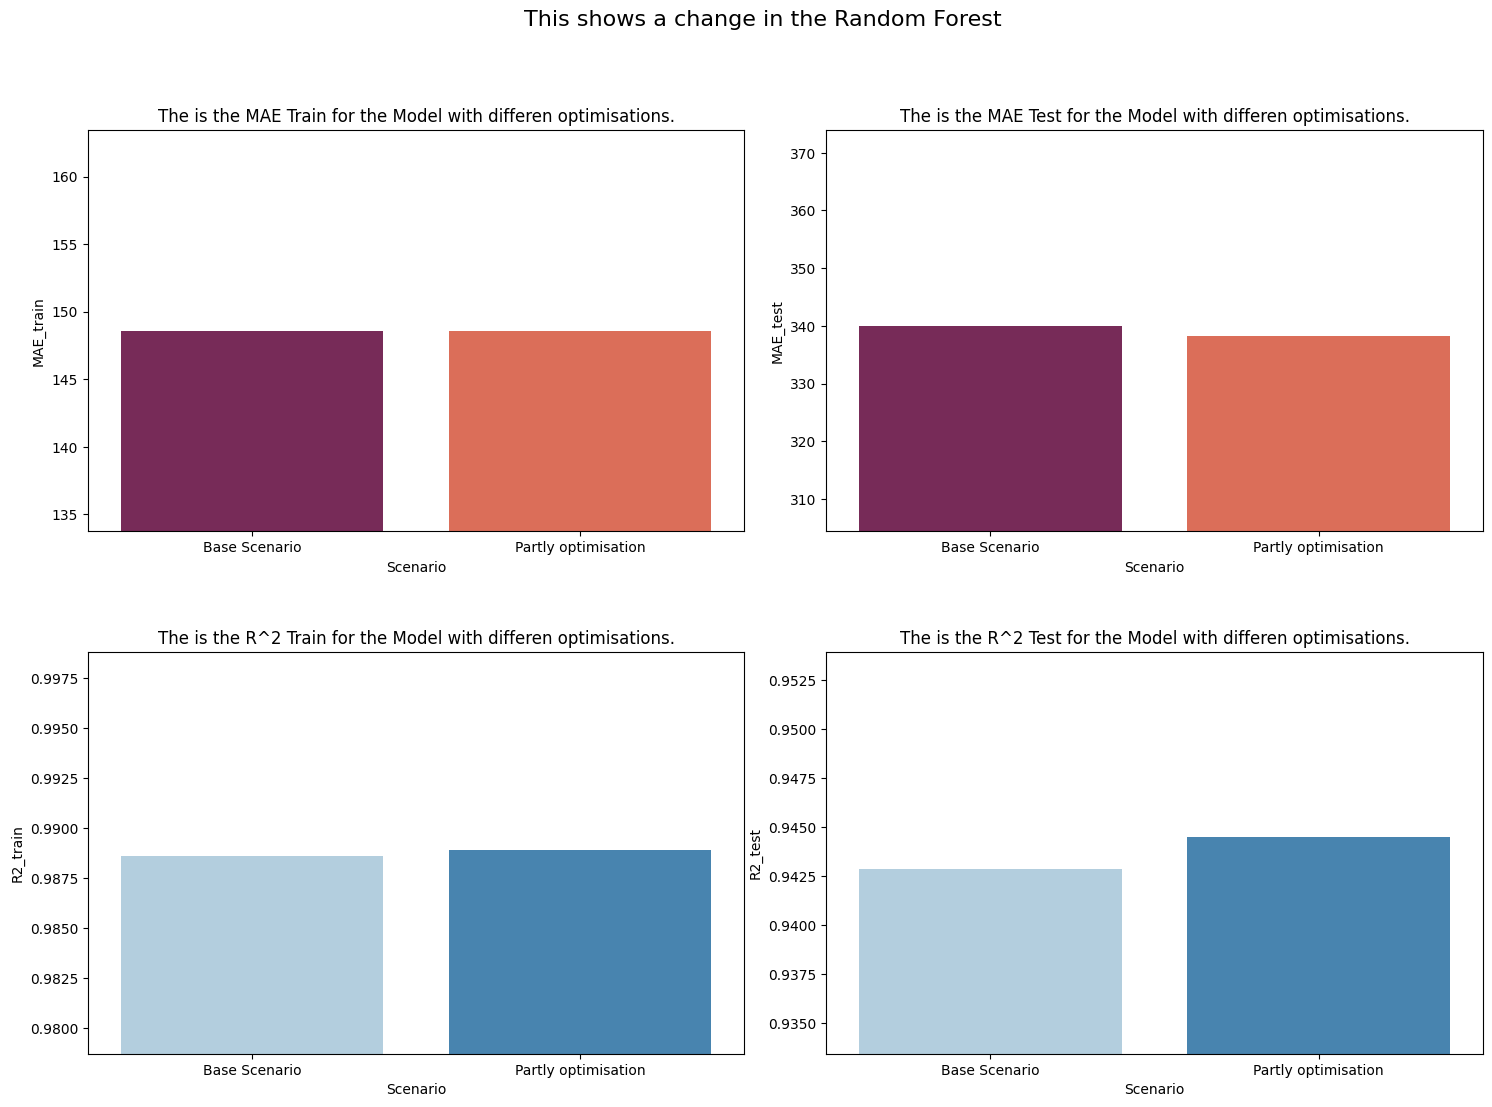

In [78]:
plot_bars_comp("Random Forest", comparison)

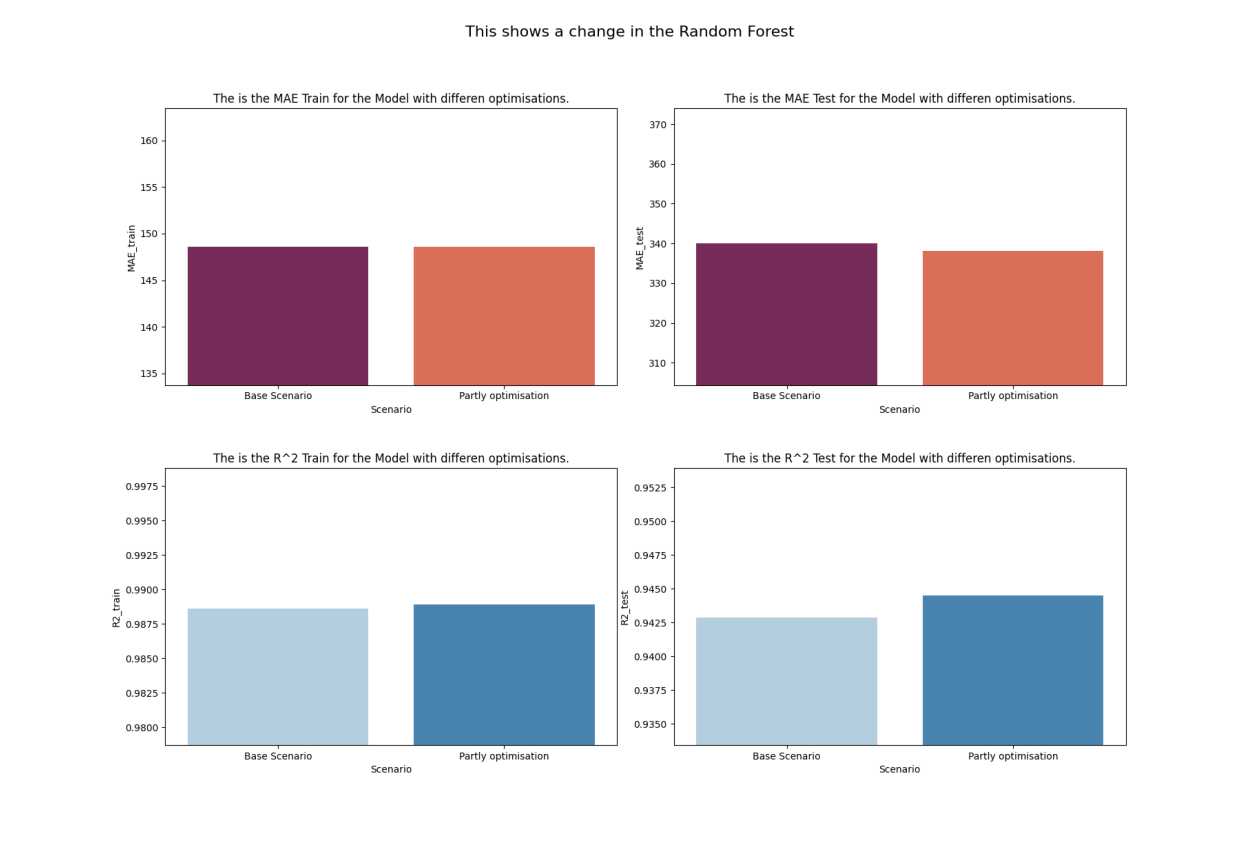

In [79]:
show_images_compa("Random Forest")

## Visualization

In [ ]:
ped = pd.read_csv("data_clean_with_dummies.csv")
ped = ped.drop(["Unnamed: 0"], axis = 1)

# Define a new X with the squared feature k = 0.99, 57+46
X = ped[ped.columns[57:103]]

y = ped["pedestrians count"]


In [ ]:
# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)




In [ ]:
# Initiate Random Forest with standard parameters as a basline
best_forest = RandomForestRegressor(random_state=144, n_jobs=-1,  n_estimators = 350, max_features = 1.0, ccp_alpha = 0.3)
best_forest.fit(Xtrain, ytrain)

In [ ]:
print(
mean_absolute_error(ytrain, best_forest.predict(Xtrain)),
mean_absolute_error(ytest, best_forest.predict(Xtest)))

### This is with all data

In [ ]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts = []
for uper in split:
    part = ped.loc[(ped["pedestrians count"] >= lower) & (ped["pedestrians count"] < uper)]
    lower = uper
    seperate_parts.append(part)



### This is with Test Data

In [ ]:
Xtest_new = Xtest.reset_index(drop=True)
ytest_new = ytest.reset_index(drop=True)

In [ ]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts_y = []
seperate_parts_x = []



for uper in split:
    y_part = ytest_new[(ytest_new >= lower) & (ytest_new < uper)]
    index_for_x = y_part.index[0:len(y_part)]
    x_part = Xtest_new.loc[index_for_x,]
    lower = uper
    seperate_parts_y.append(y_part)
    seperate_parts_x.append(x_part)



### Graph

In [ ]:
# Set up the canvas
fig, axs = plt.subplots(len(seperate_parts),2,figsize=(18, 180))
# Make a scatterplot with temperature on the x-axis and number of rentals on the y axis

#################################################
#THIS IS FOR TEST ONLY
#################################################
for i in range(len(seperate_parts_y)):
    X_calc = seperate_parts_x[i]#[seperate_parts_x[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts_y[i]#["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = best_forest.predict(X_calc)

    axs[i][0].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][0].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][0].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][0].legend()
    axs[i][0].set_xlabel("Time")
    axs[i][0].set_ylabel("People")
    axs[i][0].set_title("This are the Test Data")

#################################################
# THIS IS FOR ALL
#################################################
for i in range(len(seperate_parts)):
    X_calc = seperate_parts[i][seperate_parts[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts[i]["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = best_forest.predict(X_calc)

    axs[i][1].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][1].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][1].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][1].legend()
    axs[i][1].set_xlabel("Time")
    axs[i][1].set_ylabel("People")
    axs[i][1].set_title("This are All Data")


In [ ]:
# create figure frome saved pictures
fig = plt.figure(figsize=(20, 200))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
img1 = Image.open("pictures/per_people_test_only.png")
img2 = Image.open("pictures/per_people.png")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("Test")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("All")

# Keno

# Wanja

# API

In [ ]:
import requests # Library to access URLs using Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator


## Get Forcast weather data

### Get data

In [ ]:
# Build the  Querry for the URL
def build_query_string(base_url, params_dict):
    # Create a string of param1=value1&param2=value2&...
    params_str = "&".join(f"{k}={v}" for k,v in params_dict.items())
    # Concatenate this string with the base URL and return
    return f"{base_url}?{params_str}"

In [ ]:
# Set the API key
api_key = "ba6cf0fabcb9f0ec1029c1a0a7949ec4"

In [ ]:
# Set the base URL
geo_url = "http://api.openweathermap.org/geo/1.0/direct"

# Set the parameter to get the location
geo_params = {
    "q": "Köln",
    "appid": api_key
}

# Create the API query URL
query = build_query_string(geo_url, geo_params)

# Obtain the data from the API call
geo_data = requests.get(query).json()

In [ ]:
# Define the base URL of the forecast API
forcast_url = "https://api.openweathermap.org/data/2.5//forecast"

# Define the parameters of our query to the air pollution API
airpol_params = {
    "lat": geo_data[0]["lat"], # The latitude of our chosen city
    "lon": geo_data[0]["lon"], # The longitude of our chosen city
    "appid": api_key, # Our API key
    "units": "metric"
}

weather = requests.get(build_query_string(forcast_url, airpol_params)).json()

In [ ]:
# Extract a list of relevant dictionaries
observations_temp = []
observations_weather = []

for datapoint in weather["list"]:
    # Keep track of all temperature
    obs_t = datapoint["main"]
    # Add the date and time to the dict
    obs_t["date"] = datapoint["dt"]
    # Add the observation to the list of observations
    observations_temp.append(obs_t)

    # Keep track of all weather data
    obs_w = datapoint["weather"][0]
    # Add the date and time to the dict
    obs_w["date"] = datapoint["dt"]
    # Add the observation to the list of observations
    observations_weather.append(obs_w)

# Saving data from API in a Dataframe to merge
df_t = pd.DataFrame.from_records(observations_temp)
df_w = pd.DataFrame.from_records(observations_weather)

### Change to hourly

In [ ]:
# Merging data and changing date formate
df = pd.merge(df_t, df_w, how= "right", on = "date")
df["date"] = pd.to_datetime(df["date"], unit="s")

# buildng this as hourly with cloned rows
df_repeated = pd.concat([df]*3, ignore_index=True)
df_repeated.loc[[0,40,80]]

# Create a list to store the order of new indexs
new_index = []
# Changing the Dataframe to every hour
for n in range(int(len(df_repeated)/3)):
    new_index.append(n)
    new_index.append(n+40)
    new_index.append(n+80)

# Reset the index
df_repeated = df_repeated.reindex(new_index)
df_repeated.reset_index(inplace = True, drop = True)

# Getting a step by step change in temperature by usint the three hour steps and distripute the change evenly
for n in range(int(len(df_repeated)/3)-1):
    start_index = n*3
    end_index = (n*3)+3
    start = df_repeated.loc[start_index,"temp"]
    end = df_repeated.loc[end_index,"temp"]
    difference = end - start
    steps = round(difference/3,2)
    df_repeated.loc[start_index+1,"temp"] = df_repeated.loc[start_index,"temp"] + steps
    df_repeated.loc[start_index+2,"temp"] = df_repeated.loc[start_index,"temp"] + steps + steps

# Drop unimportant rows
df_repeated = df_repeated.drop(df_repeated.iloc[:,1:9],axis = 1)

In [ ]:
# Setting the Hour intervals for the Dataframe
for n in range(int(len(df_repeated)/3)):
    start_index = n*3
    df_repeated.loc[start_index+1,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=1)
    df_repeated.loc[start_index+2,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=2)

# Splitting the date and time for a merge
df_repeated["date"] = df_repeated["date"].astype(str)
df_repeated[["date", "time"]] = df_repeated["date"].str.split(" ", n=1, expand=True)
df_repeated

# Get Column with months
df_repeated["months"] = df_repeated["date"].str.slice(5, 7)

# Transform time to hours
df_repeated["hour"] = df_repeated["time"].str.slice(0, 2)

### Future School Holiday

In [ ]:
# Import Dataframe from the holidays
future_school_holi = pd.read_csv("future_school_holiday.csv", sep = ";")
days_df_list = []

# Create dataframe with all dates singular listed 
for i in range(future_school_holi.shape[0]):
    # Get the start and enddate from the holidays
    start_date = datetime.strptime(future_school_holi["Erster Ferientag"][i], "%Y-%m-%d").date()
    end_date = datetime.strptime(future_school_holi["Letzter Ferientag"][i], "%Y-%m-%d").date()

    # Create dataframes out of the range and append to a list
    delta = end_date - start_date
    days = [start_date + timedelta(days=n) for n in range(delta.days + 1)]
    days_df = pd.DataFrame (days, columns = ["date"])
    days_df_list.append(days_df)

# Create single dataframe out of the list and add value 1 for holiday
new_holi = pd.concat(days_df_list).reset_index(drop=True)
new_holi["school holiday"] = 1

# Chagne to str for merge
new_holi["date"] = new_holi["date"].astype(str)

In [ ]:
# Merging the weather data an the holidays
df_merge1 = pd.merge(df_repeated, new_holi, how= "left", on = "date")
# Filling cells with no holiday with a 0
df_merge1["school holiday"] = df_merge1["school holiday"].fillna(0)
# change float to int
df_merge1["school holiday"] = np.int64(df_merge1["school holiday"].astype(int))

### Future National Holiday

In [ ]:
# Getting the current year 
today = dt.date.today()
year = int(today.strftime("%Y"))

# Putting this and the next year into a list to claculate the holidays
this_plus_next_year = [year,year + 1]

future_holidays_list = []

for intput_year in this_plus_next_year:
    # Formular for calculating easter sunday
    k = intput_year // 100
    m = 15 + (3 * k + 3) // 4 - (8 * k + 13) // 25
    s = 2 - (3*k + 3) // 4
    a = intput_year % 19

    d = (19* a + m) % 30
    r = (d + a // 11) // 29
    og = 21 + d - r
    sz = 7 - (intput_year + intput_year // 4 + s) % 7

    oe =  7 - (og - sz) % 7

    # Days for easter sunday after teh first march (because daytime starts at first minus 1 again)
    os = og + oe -1
    first_march = date(intput_year, 3, 1)

    # Calculating the date for easter sunday
    os_date = first_march + timedelta(days=os)


    # The flexible holidays calculated from easter sunday
    karfreitag = os_date - timedelta(days=2)
    os_date = os_date
    easter_monday = os_date + timedelta(days=1)
    ascension = os_date + timedelta(days=39)
    white_monday = os_date + timedelta(days=50)
    corpus_christ = os_date + timedelta(days=60)

    # The fixed holidays (for nrw)
    new_year = date(intput_year, 1, 1)
    day_of_work = date(intput_year, 5, 1)
    germany_united = date(intput_year, 10, 3)
    saints_day = date(intput_year, 11, 1)
    first_christmas = date(intput_year, 12, 25)
    second_christmas =date(intput_year, 11, 26)

    # Creating dataframe with holidays
    holiday_list_future = [new_year, karfreitag, os_date, easter_monday, day_of_work, ascension, white_monday, corpus_christ, germany_united, saints_day, first_christmas, second_christmas]
    future_holidays = pd.DataFrame ({"date": holiday_list_future,
                                    "holiday": [1 for i in range(len(holiday_list_future))]})
    future_holidays_list.append(future_holidays)

# Connect the holidays from this and the nex year
df_future_holidays = pd.concat(future_holidays_list)

In [ ]:
# Merging the holidays with the alredy merged dataframe
df_merge2 = pd.merge(df_merge1, df_future_holidays, how= "left", on = "date")
# Fill no holidays with zeros
df_merge2["holiday"] = df_merge2["holiday"].fillna(0)
#change float to int
df_merge2["holiday"] = np.int64(df_merge2["holiday"].astype(int))

### Getting the training data for Pedestriants

In [ ]:
#Getting the Dataframe for the prediction without pca
ped = pd.read_csv("data_clean_without_dummies.csv", sep = ";", index_col=0)
#restructure month for later
ped["months"] = ped["months"].astype(str)
ped["months"] = ped["months"].str.zfill(2)

In [ ]:
# Putting the holidays in the last two places to mak it easier to assign the parameters for learning

def reindexing(column_name, dataframe):
    return dataframe.reindex(columns = [col for col in dataframe.columns if col != column_name] + [column_name])

ped = reindexing("school holiday", ped)
ped = reindexing("holiday", ped)

### Creating dummies for the weather

In [ ]:
#Values from weather and key from pedestriant data
######################################################
# Because the API Used by the pedestriant count is no longer the old provider and not free, we used another API. This does not match all the Notations regarding the weather, so we had to set the Drizzle equal with Wind.
# This is not 100% Accuarte but is also not that comon in the dataset or the API. Furthermore we had to set all other variables in Atmosphere Group (ID7xx) from the weather api besides Mist to nan. Bu since Ash, Tornados, etc. are not that comon in 
# Köln this does not have a big impact.  
#######################################################
dict_weather = {'rain':"Thunderstorm",
                'wind':"Drizzle",
                'rain':"Rain",
                "snow":"Snow",
                "fog":'Mist',
                "clear-night":"Clear",
                "clear-day":"Clear",
                "cloudy":"Clouds",
                "partly-cloudy-night":"Clouds",
                "partly-cloudy-day":"Clouds",
                }


# Create columns with rows for zero, becuase we dont use get_dummies, to be sure it is not mixing the rows up
def create_columns_dict(dataframe, dict_col):
    for col_name in dict_col.values():
        dataframe[col_name] = 0

# Use the function for boath datasets
create_columns_dict(ped, dict_weather)
create_columns_dict(df_merge2, dict_weather)


# Fill the according columns in both Datasets for the weather 
def fill_weather(dataframe, column, dictionary):
    for i in range(len(dataframe)):
        weather = dataframe.loc[i, column]
# For pedestraints or for weather
        value = next((v for k, v in dict_weather.items() if v == weather or k == weather), "nan")
        dataframe.loc[i, value] = 1


# Using the function for the Weather data and the Pedestirants data
fill_weather(ped, "weather condition", dict_weather)
fill_weather(df_merge2, "main", dict_weather)


### Creating dummies for the months

In [ ]:
# Create a function to create and fill the Columns of the months
def fill_months(data_frame, Month_list, Column):
    for month in Month_list:
        data_frame[month] = 0
    for i in range(len(data_frame)):
        month = data_frame.loc[i, Column]
        for number_months in range(len(Month_list)):
            number_months_str = str(number_months+1).zfill(2)
            if month == number_months_str:
                data_frame.loc[i, Month_list[number_months]] = 1

In [ ]:
# Create a list wiht all months
Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Using the function for the Weather data and the Pedestirants data
fill_months(df_merge2, Months, "months")
fill_months(ped, Months, "months")


### Creating dummies for the weekdays

In [ ]:
# Create a function to create and fill the Columns of the months
def fill_weekdays(data_frame, Weekdays_list, Column):
    for days in Weekdays_list:
        data_frame[days] = 0
    for i in range(len(data_frame)):
        if Column == "weekday":
            day = data_frame.loc[i, "weekday"]
        if Column != "weekday":
            day = datetime.strptime(data_frame.loc[i, "date"], "%Y-%m-%d").strftime('%A')
        for weekday in Weekdays_list:
            if day == weekday:
                data_frame.loc[i, weekday] = 1



In [ ]:
#Create list with weekdays
Weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Using the function for the Weather data and the Pedestirants data
fill_weekdays(df_merge2, Weekdays, "date")
fill_weekdays(ped, Weekdays, "weekday")


### Creating dummies for the hours 

In [ ]:
# Create a function to create and fill the Columns of the months
def fill_hours(data_frame, Column):
    # Creating columns with the hours and setting them 0
    hour_in_day =  list(data_frame[Column].unique())
    hour_in_day.sort()
    for time in hour_in_day:
      data_frame[time] = 0
    # Going over the dataframe and changing to 1
    for i in range(len(data_frame)):
        time = data_frame.loc[i, Column]
        for hour in hour_in_day:
            if time == hour:
                data_frame.loc[i, time] = 1

In [ ]:
# Using the function for the Weather data and the Pedestirants data
fill_hours(df_merge2, "time")
fill_hours(ped, "time")

### Standardize the temperature

In [ ]:
# Use the mean and the std from the Pedestirants data
mean_used = ped["temperature in ºc"].mean()
std_used = ped["temperature in ºc"].std()

# Create a function to standardize
def standardize(df, column, mean, std):
    df["temperature"] = (df[column] - mean) / std

# Using the function for the Weather data and the Pedestirants data
standardize(ped, "temperature in ºc", mean_used, std_used)
standardize(df_merge2, "temp", mean_used, std_used)

# Save the pedestraint data
ped.to_csv("Pedestriant_df_for_forecast.csv", sep=";")

## Forcasting

### Training Data

In [ ]:
ped = pd.read_csv("Pedestriant_df_for_forecast.csv", sep=";", index_col=0)
# Define a X
X = ped[ped.columns[8:]]
# Output to predict
y = ped["pedestrians count"]


# Define a X for the forecast
X_forecast = df_merge2[df_merge2.columns[9:]]


# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [ ]:
examplatory_forecast_model = RandomForestRegressor(random_state=144,n_jobs=-1)
examplatory_forecast_model.fit(Xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=144)

In [ ]:
def get_mae(y_data, x_data, model):
    mae = mean_absolute_error(y_data, model.predict(x_data))
    return mae
    
mae_train = get_mae(ytrain, Xtrain, examplatory_forecast_model)
mae_test = get_mae(ytest, Xtest, examplatory_forecast_model)

print(mae_train, mae_test)

165.53614813040707 379.2583677352017


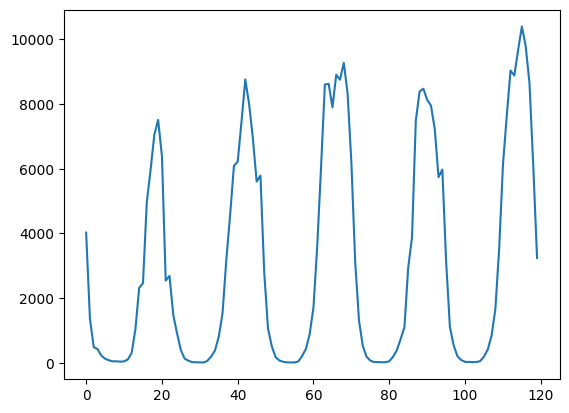

In [ ]:
forecast = examplatory_forecast_model.predict(X_forecast)

forecast = [int(round(item, 0)) for item in forecast]


df_merge2["forecast"] = forecast

plt.plot(forecast)
